In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pdb
import os
import seaborn as sns
from collections import OrderedDict
import random 
import pickle
from scipy import linalg, stats
import pandas as pd
import random
import msprime
# from IPython.display import SVG, displaydf 
import seaborn as sns
from scipy import special
from matplotlib.patches import Rectangle
import time
import joblib
from scipy.ndimage import distance_transform_edt


In [2]:
import pybedtools

In [3]:
# path prefix to save all figures
path_prefix_figures = '/home/tc557/twin_peaks/twinpeaks_240813/plots'
if os.path.isdir(path_prefix_figures) is False:
    os.mkdir(path_prefix_figures)
path_suffix = '240724_2000.pdf'
path_suffix_png = '240724_2000.png'

In [6]:
plt.rcParams['figure.figsize'] = [24, 16] 
plt.rcParams.update({'font.size': 50})
# plt.plot([1,2,3],[1,2,3])


In [7]:
def time_intervals(D,spread_1,spread_2): 
    T = [0]
    # for i in range(0,D-1): 
    #     T.append( spread_1*np.exp( (i/D)*np.log(1 + spread_2/spread_1) - 1))
    # T.append(T[-1]*10) # append stupidly large last tMRCA to represent infinity
    for i in range(0,D): 
        T.append( spread_1*np.exp( (i/D)*np.log(1 + spread_2/spread_1) - 1))
    # T.append(T[-1]*10) # append stupidly large last tMRCA to represent infinity

    T_np = np.array(T)
    return T_np

In [10]:
with open('/home/tc557/rds/hpc-work/cobraa_snakemakes/PSMCplus_231026/igsr_populations_micro.txt','r') as f:
    lines = f.readlines()
    
tripletcodes_popnames = {}
for line in lines:
    triplet = line.split('\t')[0]
    popname = line.split('\t')[1].split('\n')[0]
    tripletcodes_popnames[triplet] = popname
    
tripletcodes_popnames

{'FIN': 'Finnish_in_Finland',
 'CHS': 'Han_Chinese_South',
 'KHV': 'Vietnamese_Kinh_in_Ho_Chi_Minh_City,_Vietnam',
 'BEB': 'Bengali_in_Bangladesh',
 'PUR': 'Puerto_Rican_in_Puerto_Rico',
 'ACB': 'African_Caribbean_in_Barbados',
 'ASW': 'African_Ancestry_in_Southwest_US',
 'YRI': 'Yoruba_in_Ibadan,_Nigeria',
 'GWD': 'Gambian_in_Western_Division,_The_Gambia_-_Mandinka',
 'JPT': 'Japanese_in_Tokyo,_Japan',
 'MSL': 'Mende_in_Sierra_Leone',
 'CEU': 'Utah_residents_(CEPH)_with_Northern_and_Western_European_ancestry',
 'ESN': 'Esan_in_Nigeria',
 'CHB': 'Han_Chinese_in_Beijing,_China',
 'CLM': 'Colombian_in_Medellin,_Colombia',
 'CDX': 'Chinese_Dai_in_Xishuangbanna,_China',
 'PEL': 'Peruvian_in_Lima,_Peru',
 'PJL': 'Punjabi_in_Lahore,_Pakistan',
 'IBS': 'Iberian_populations_in_Spain',
 'TSI': 'Toscani_in_Italy',
 'MXL': 'Mexican_Ancestry_in_Los_Angeles,_California',
 'LWK': 'Luhya_in_Webuye,_Kenya',
 'GIH': 'Gujarati_Indians_in_Houston,_TX',
 'STU': 'Sri_Lankan_Tamil_in_the_UK',
 'ITU': 'India

In [11]:
pop_and_sample = [
    'GBR_HG00118',
    'TSI_NA20752',
    'IBS_HG01783',
    'FIN_HG00266',
    'CEU_NA12718',
    'CHS_HG00443',
    'KHV_HG02113',
    'CHB_NA18530',
    'CDX_HG02373',
    'JPT_NA18939',
    'BEB_HG03006',
    'PJL_HG03234',
    'GIH_NA20845',
    'STU_HG03753',
    'ITU_HG03977',
    'PUR_HG01171',
    'CLM_HG01250',
    'PEL_HG02285',
    'MXL_NA19648',
    'ESN_HG03515',
    'YRI_NA18488',
    'MSL_HG03212',
    'GWD_HG02568',
    'ACB_HG01882',
    'ASW_NA19625',
    'LWK_NA19017'    
]

 
pop_and_sample_africans = [
    'ESN_HG03515',
    'YRI_NA18488',
    'MSL_HG03212',
    'GWD_HG02568',
    'ACB_HG01882',
    'ASW_NA19625',
    'LWK_NA19017'    
]

populations = [i.split('_')[0] for i in pop_and_sample]

pop_colors = {}
# European
pop_colors['GBR'] = 'darkturquoise'
pop_colors['TSI'] = 'mediumblue'
pop_colors['IBS'] = 'deepskyblue'
pop_colors['FIN'] = 'lightskyblue'
pop_colors['CEU'] = 'royalblue'


# South East and Central Asian
pop_colors['CHS'] = 'lightcoral'
pop_colors['KHV'] = 'indianred'
pop_colors['CHB'] = 'brown'
pop_colors['CDX'] = 'maroon'
pop_colors['JPT'] = 'red'

# South Asian 
pop_colors['BEB'] = 'violet'
pop_colors['PJL'] = 'darkorchid'
pop_colors['GIH'] = 'purple'
pop_colors['STU'] = 'magenta'
pop_colors['ITU'] = 'orchid'

# South American
pop_colors['PUR'] = 'peru'
pop_colors['CLM'] = 'darkorange'
pop_colors['PEL'] = 'wheat'
pop_colors['MXL'] = 'goldenrod'

# African
pop_colors['ESN'] = 'olivedrab'
pop_colors['YRI'] = 'greenyellow'
pop_colors['MSL'] = 'lawngreen'
pop_colors['GWD'] = 'forestgreen'
pop_colors['ACB'] = 'seagreen'
pop_colors['ASW'] = 'green'
pop_colors['LWK'] = 'springgreen'

In [16]:
D = 64
b = 100
spread1 = 0.075
spread2s = [50,100,150,200]
iterations = 30
thresh = 1
muoverr = 1.5 # starting mu over r ratio
fixedtheta = 0.0008
chroms = range(1,23)
T = time_intervals(D,spread1,spread2s[0])
gen = 29
mu=1.25e-08
thetafixed=0.0008



## Decoding

In [54]:

D = 64
b = 100
spread1 = 0.075
spread2s = [50,100,150,200]
iterations = 30
thresh = 1
muoverr = 1.5 # starting mu over r ratio
fixedtheta = 0.0008
chroms = range(1,23)
T = time_intervals(D,spread1,spread2s[0])
gen = 29
mu=1.25e-08
thetafixed=0.0008
step_size = 1000 # decode is written every 1k base pairs

N=thetafixed/(4*mu)
spread2=50
T_coalescent = time_intervals(D,spread1,spread2)
T_gens = T_coalescent*2*N
T_years = T_gens*29
T_years = T_gens*29
T_years_ = np.concatenate([T_years,[5e+07]])
T_years_midpoints = np.array([(T_years[i]+T_years[i+1])/2 for i in range(0,D)])

In [ ]:
# don't run this again

posterior_sums_pops = {}
for popsam in pop_and_sample:
    posterior_sums_pops[popsam] = np.zeros(shape=D)
for popsam in pop_and_sample:
    print(f'popsam={popsam}')
    for chrom in range(1,23):
        print(f'\tchrom={chrom}')
        filename = f'/home/tc557/rds/hpc-work/PSMCplus_analysis_240813/240813/D_{D}/b_{b}/spread1_{spread1}/spread2_{spread2}/muoverr_{muoverr}/iterations{iterations}/thresh_{thresh}/thetafixed_{thetafixed}/popsample_{popsam}/chr{chrom}_decode.txt.gz'
        position_decoding = np.loadtxt(filename)
        position = position_decoding[0,:]
        posterior = position_decoding[1:,:]
        posterior_sums_pops[popsam] += posterior.sum(axis=1)
    
    #     print(f'zpdf.sum() = {zpdf.sum()}')

In [55]:
# filename = f'/home/tc557/rds/hpc-work/twin_peaks/analysis_240813/D{D}_b{b}_spread1{spread1}_spread2{spread2}_muoverr{muoverr}_iterations{iterations}_thresh{thresh}_thetafixed{thetafixed}_summedpdf_allpops.pickle'
# with open(filename,'wb') as f:
#     pickle.dump(posterior_sums_pops,f)

filename = f'/home/tc557/rds/hpc-work/twin_peaks/analysis_240813/D{D}_b{b}_spread1{spread1}_spread2{spread2}_muoverr{muoverr}_iterations{iterations}_thresh{thresh}_thetafixed{thetafixed}_summedpdf_allpops.pickle'
with open(filename,'rb') as f:
    posterior_sums_pops = pickle.load(f)

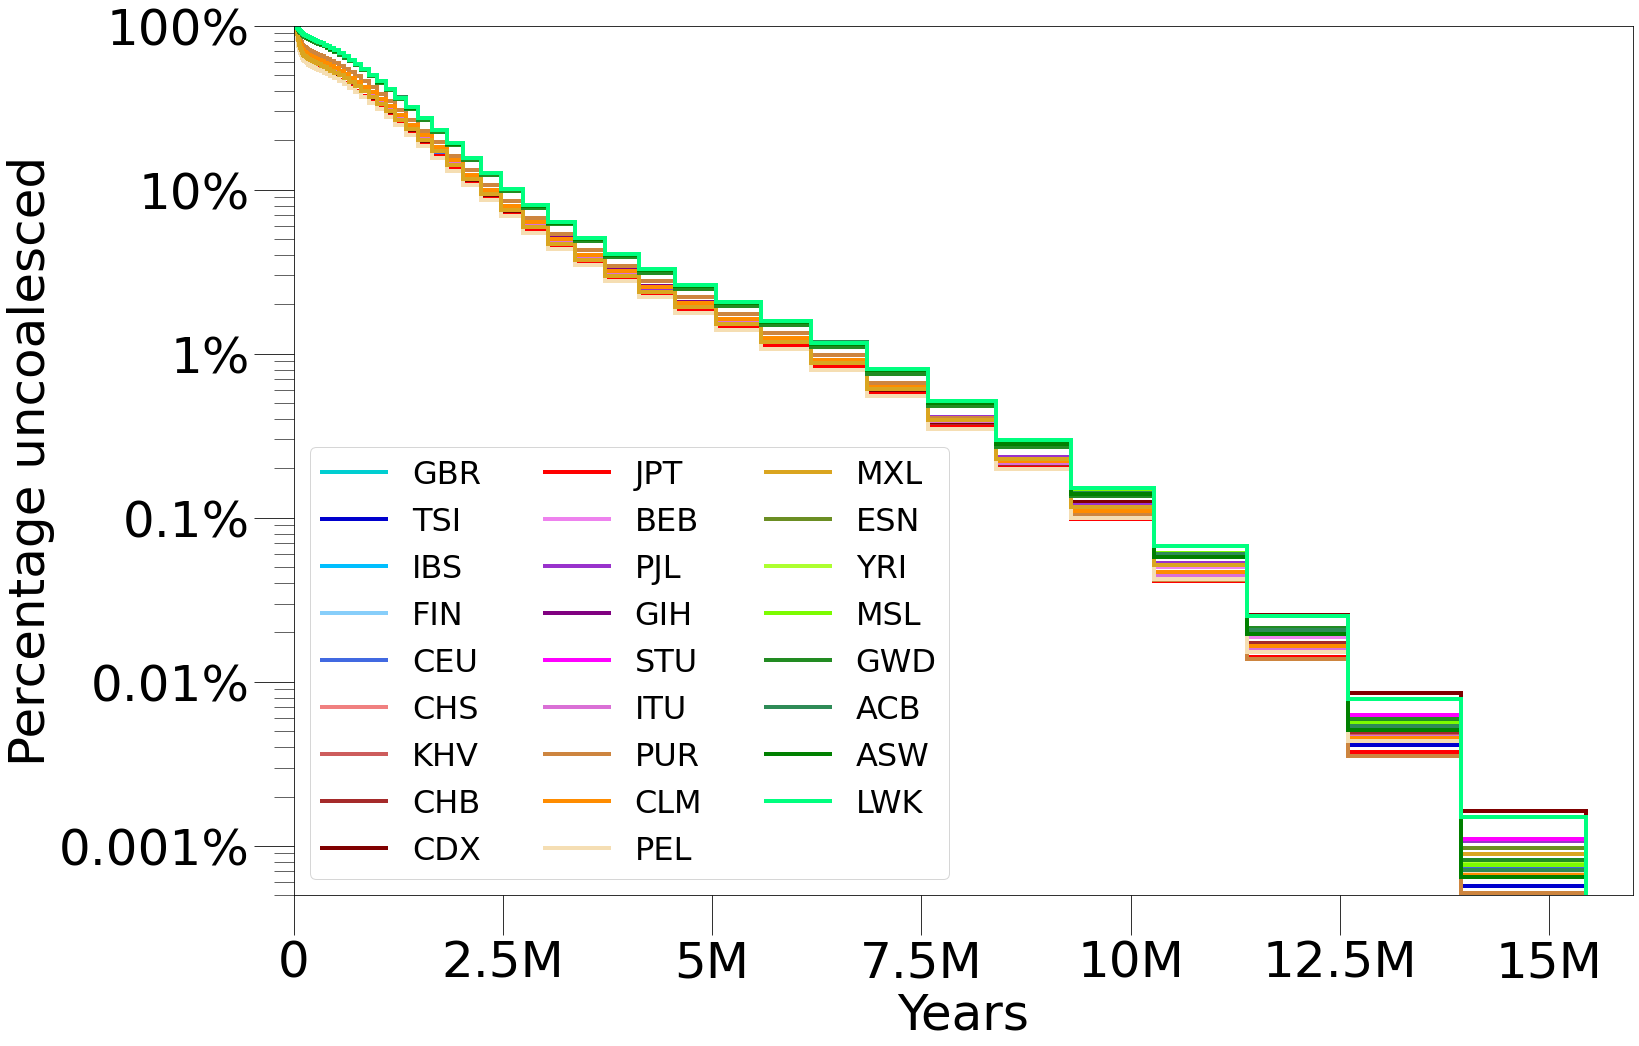

In [57]:
for popsam in pop_and_sample:
#     print(f'popsam={popsam}')
    # plt.stairs(edges=T_years,values=pdf)
    zpdf = posterior_sums_pops[popsam]    
    pdf = zpdf/zpdf.sum()
    CDF = np.array([pdf[0:i].sum() for i in range(0,D+1)])
    zpop=popsam.split('_')[0]
    plt.stairs(edges=T_years_,values=100*(1-CDF),baseline=None,color=pop_colors[zpop],label=popsam.split('_')[0],linewidth=4)
    # plt.xscale('log')
plt.yscale('log')
plt.ylabel('Percentage uncoalesced')
plt.xlabel('Years')
plt.tick_params(which='major',length=40)
plt.tick_params(which='minor',length=20)
plt.yticks(ticks=[1e-03,1e-2,1e-1,1,10,100],labels=['0.001%','0.01%','0.1%','1%','10%','100%'])
plt.xticks(ticks=np.arange(0,2.25e+07,2.5e+06),labels=['0','2.5M','5M','7.5M','10M','12.5M','15M','17.5M','20M'])
plt.xlim(0,1.6e+07)
plt.ylim(0.0005,100)
plt.legend(loc="lower left",ncol=3,fontsize=32)
plot_name = f"plot_PSMCplus_1KGP_thetafixed{thetafixed}_D{D}_b{b}_iterations{iterations}_spread2{spread2}_fractionuncoalesced"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  

plt.show()


In [ ]:
chrom=20
posterior_mean_pops = {}   
for popsam in pop_and_sample:
    print(f'popsam={popsam}')
    filename = f'/home/tc557/rds/hpc-work/PSMCplus_analysis_240813/240813/D_{D}/b_{b}/spread1_{spread1}/spread2_{spread2}/muoverr_{muoverr}/iterations{iterations}/thresh_{thresh}/thetafixed_{thetafixed}/popsample_{popsam}/chr{chrom}_decode.txt.gz'
    position_decoding = np.loadtxt(filename)
    position = position_decoding[0,:]
    posterior = position_decoding[1:,:]
    posterior_means = np.multiply(posterior,T_years_midpoints[:,np.newaxis]).sum(axis=0)
    posterior_mean_pops[popsam] = posterior_means

In [ ]:
chrom=1
posterior_mean_pops_chr1 = {}   
for popsam in pop_and_sample:
    print(f'popsam={popsam}')
    filename = f'/home/tc557/rds/hpc-work/PSMCplus_analysis_240813/240813/D_{D}/b_{b}/spread1_{spread1}/spread2_{spread2}/muoverr_{muoverr}/iterations{iterations}/thresh_{thresh}/thetafixed_{thetafixed}/popsample_{popsam}/chr{chrom}_decode.txt.gz'
    position_decoding = np.loadtxt(filename)
    position = position_decoding[0,:]
    posterior = position_decoding[1:,:]
    posterior_means = np.multiply(posterior,T_years_midpoints[:,np.newaxis]).sum(axis=0)
    posterior_mean_pops_chr1[popsam] = posterior_means
    posterior_mean_pops_chr1[f'{popsam}_position'] = position
    

In [56]:
# filename = f'/home/tc557/rds/hpc-work/twin_peaks/analysis_240813/posteriormeans_all_pops_chr1.pickle'
# with open(filename,'wb') as f:
#     pickle.dump(posterior_mean_pops_chr1,f)

filename = f'/home/tc557/rds/hpc-work/twin_peaks/analysis_240813/posteriormeans_all_pops_chr1.pickle'
with open(filename,'rb') as f:
    posterior_mean_pops_chr1 = pickle.load(f)

In [ ]:
chrom=6
posterior_mean_pops_chr6 = {}   
for popsam in pop_and_sample:
    print(f'popsam={popsam}')
    filename = f'/home/tc557/rds/hpc-work/PSMCplus_analysis_240813/240813/D_{D}/b_{b}/spread1_{spread1}/spread2_{spread2}/muoverr_{muoverr}/iterations{iterations}/thresh_{thresh}/thetafixed_{thetafixed}/popsample_{popsam}/chr{chrom}_decode.txt.gz'
    position_decoding = np.loadtxt(filename)
    position = position_decoding[0,:]
    posterior = position_decoding[1:,:]
    posterior_means = np.multiply(posterior,T_years_midpoints[:,np.newaxis]).sum(axis=0)
    posterior_mean_pops_chr6[popsam] = posterior_means
    posterior_mean_pops_chr6[f'{popsam}_position'] = position
    

In [14]:
minlength = 1e+10
for popsam in pop_and_sample:
    zzlength = len(posterior_mean_pops_chr1[popsam])
    if zzlength<minlength:
        minlength=zzlength
        
posteriors_matrix_allpops = np.zeros(shape=(26,minlength))
for c,popsam in enumerate(pop_and_sample):
    posteriors_matrix_allpops[c,:] = posterior_mean_pops_chr1[popsam][0:minlength]


/tmp/ipykernel_3955098/2548352170.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]);  # Adjust rect to account for the colorbar


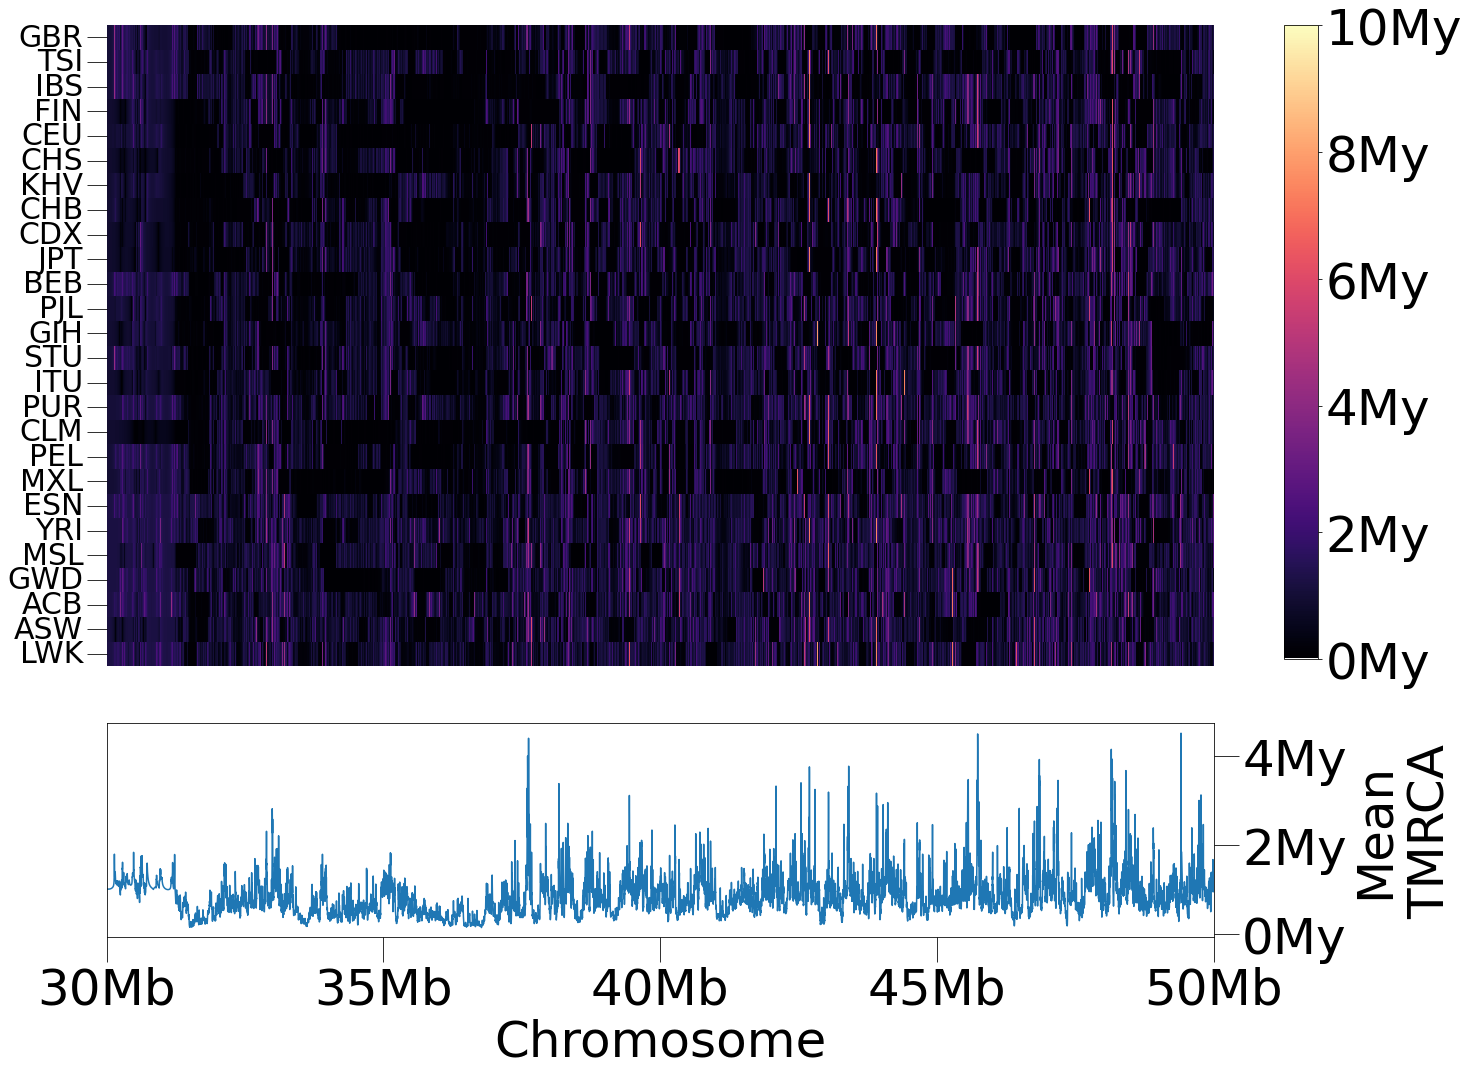

In [39]:

# Set the figure and font size
plt.rcParams['figure.figsize'] = [24, 12] 
plt.rcParams.update({'font.size': 50})

# Define start and end positions for slicing the matrix
start_bp = 3e+07
end_bp = 5e+07
step_size = 1000  
start = int(start_bp // step_size)
end = int(end_bp // step_size)

# Define x-axis labels and positions
xlabels = ['30Mb','35Mb','40Mb','45Mb','50Mb']
xpositions = [0, 5000, 10000, 15000, 20000]

# Create figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(24, 16), gridspec_kw={'height_ratios': [3, 1]})

# First plot (heatmap)
ax1 = sns.heatmap(posteriors_matrix_allpops[:, start:end], cmap="magma", ax=axs[0], cbar=False,vmax=1e+07)

# Manually add the colorbar
c_bar_ax = fig.add_axes([0.77, 0.4, 0.02, 0.55])  # Position the colorbar outside the heatmap
c_bar = fig.colorbar(ax1.get_children()[0], cax=c_bar_ax)
c_bar.set_ticks([0, 2e+06, 4e+06, 6e+06, 8e+06, 10e+06])
c_bar.set_ticklabels([f'{i}My' for i in [0, 2, 4, 6, 8, 10]])
# c_bar.tick_params(which='major', length=10)


# Adjust the position of ax1 to leave space for the colorbar
pos1 = ax1.get_position()  # Get the original position of ax1
ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])  # Adjust to make space for colorbar

# Set y-axis labels and ticks for heatmap
ax1.set_yticks(ticks=np.arange(0, 26, 1) + 0.5, labels=populations, rotation=0, fontsize=30)
# ax1.set_xticks(ticks=xpositions, labels=xlabels, rotation=0, fontsize=50)
ax1.set_xticks([])
ax1.tick_params(which='major', length=20)
ax1.tick_params(which='minor', length=10)

# Second plot (line plot)
ax2 = axs[1]
ax2.plot(posteriors_matrix_allpops[:, start:end].mean(axis=0))

# Set labels and ticks for ax2
ax2.set_xlabel('Chromosome')
ax2.set_ylabel('Mean\nTMRCA')
ax2.set_xlim(0,end-start)
ypositions = np.arange(0, 5e+06, 2e+06)
ylabels = [f'{i}My' for i in [0, 2, 4]]
ax2.yaxis.set_label_position("right")
ax2.set_xticks(ticks=xpositions, labels=xlabels, rotation=0, fontsize=50)
ax2.set_yticks(ticks=ypositions, labels=ylabels, rotation=0, fontsize=50)
ax2.yaxis.tick_right()
ax2.tick_params(which='major', length=25)
ax2.tick_params(which='minor', length=10)

# Adjust layout to avoid overlapping of subplots and ensure alignment
plt.tight_layout(rect=[0, 0, 0.9, 1]);  # Adjust rect to account for the colorbar

plot_name = f"plot_PSMCplus_1KGP_thetafixed{thetafixed}_D{D}_b{b}_iterations{iterations}_spread2{spread2}_heatmapposteriormeans_chr20"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plot_name = f"plot_PSMCplus_1KGP_thetafixed{thetafixed}_D{D}_b{b}_iterations{iterations}_spread2{spread2}_heatmapposteriormeans_chr20"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix_png}',bbox_inches='tight')  

# Display the plots
plt.show()


zmintime=1000000.0; cor=pearson;
	0.29952776656279756
	max pval=0.0


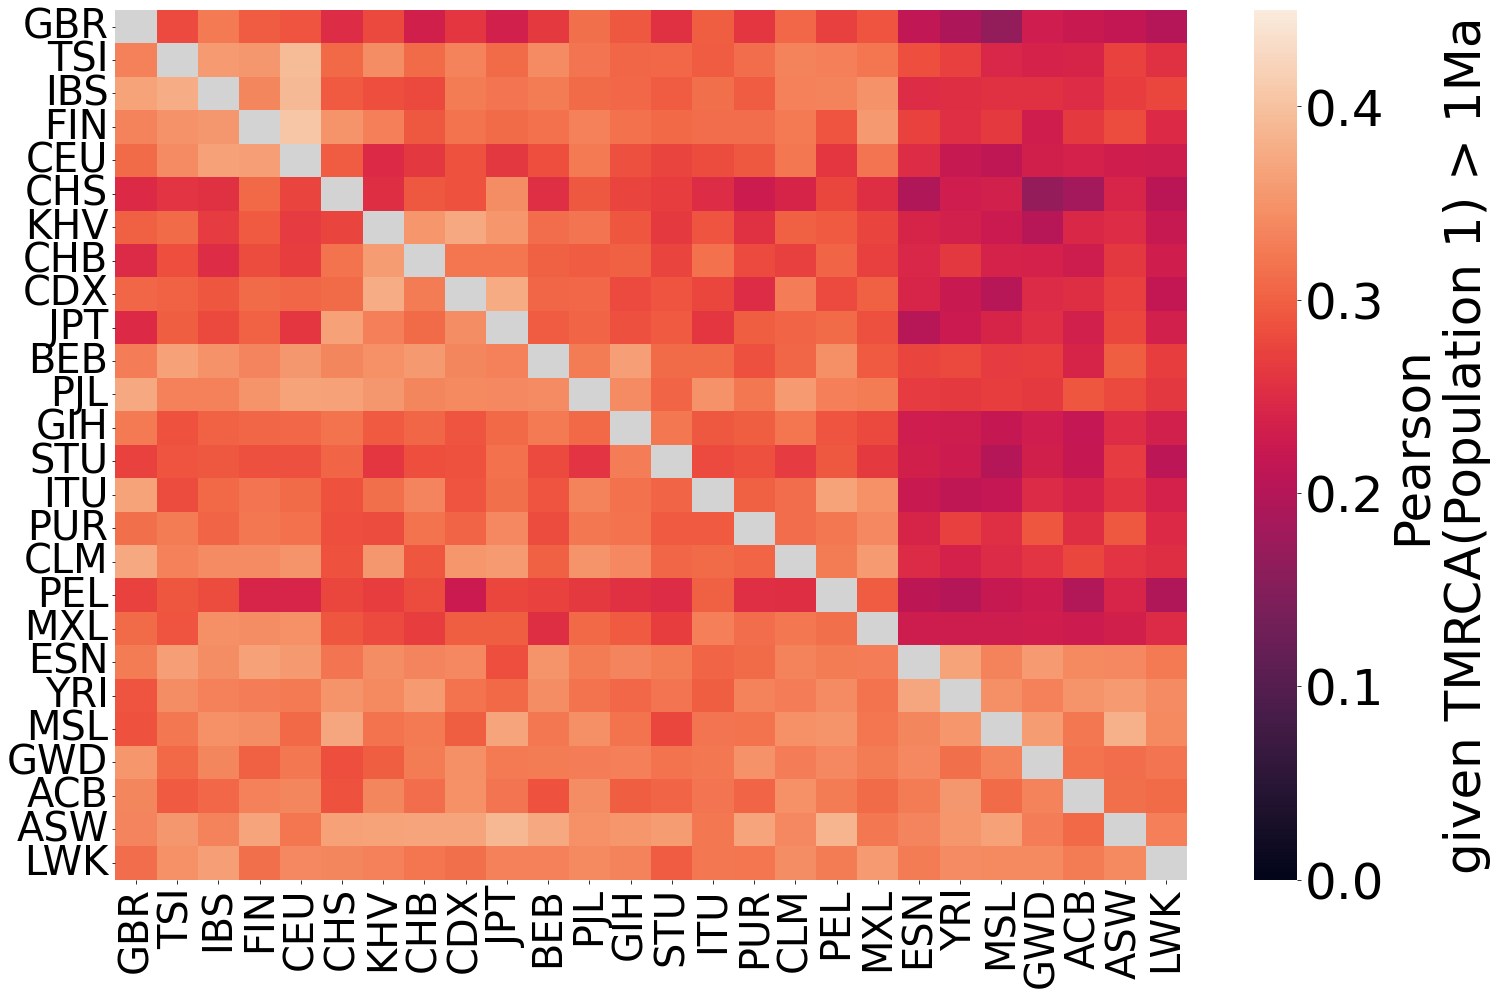

zmintime=2000000.0; cor=pearson;
	0.26357874973271994
	max pval=1.5672037516999163e-87


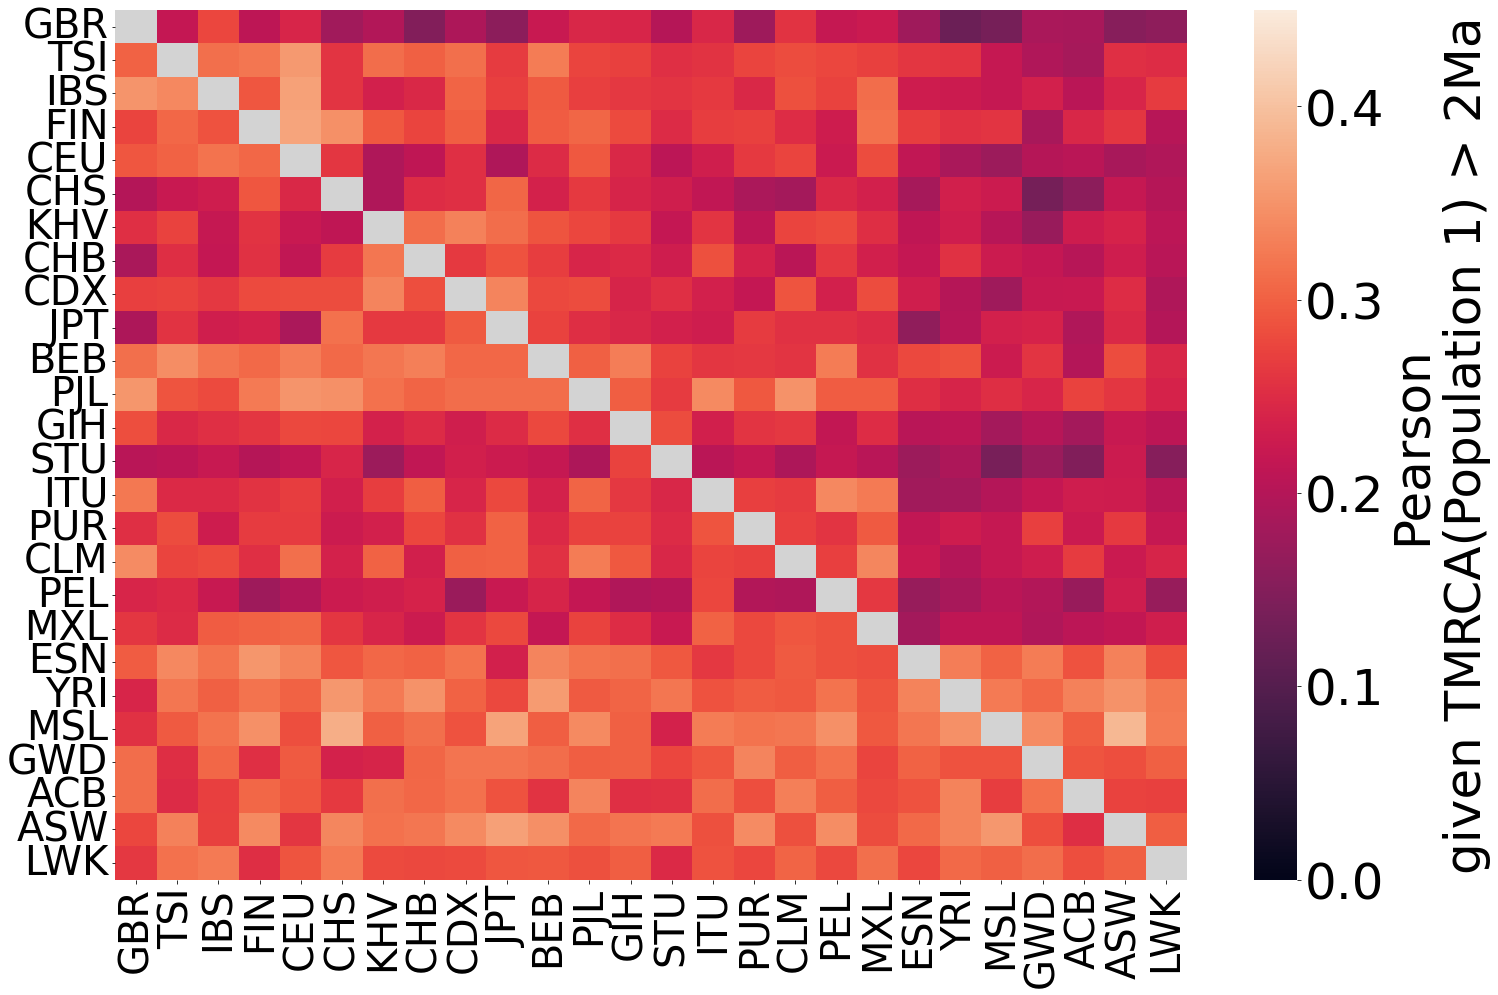

zmintime=3000000.0; cor=pearson;
	0.20935893199160638
	max pval=1.7293405298466854e-09


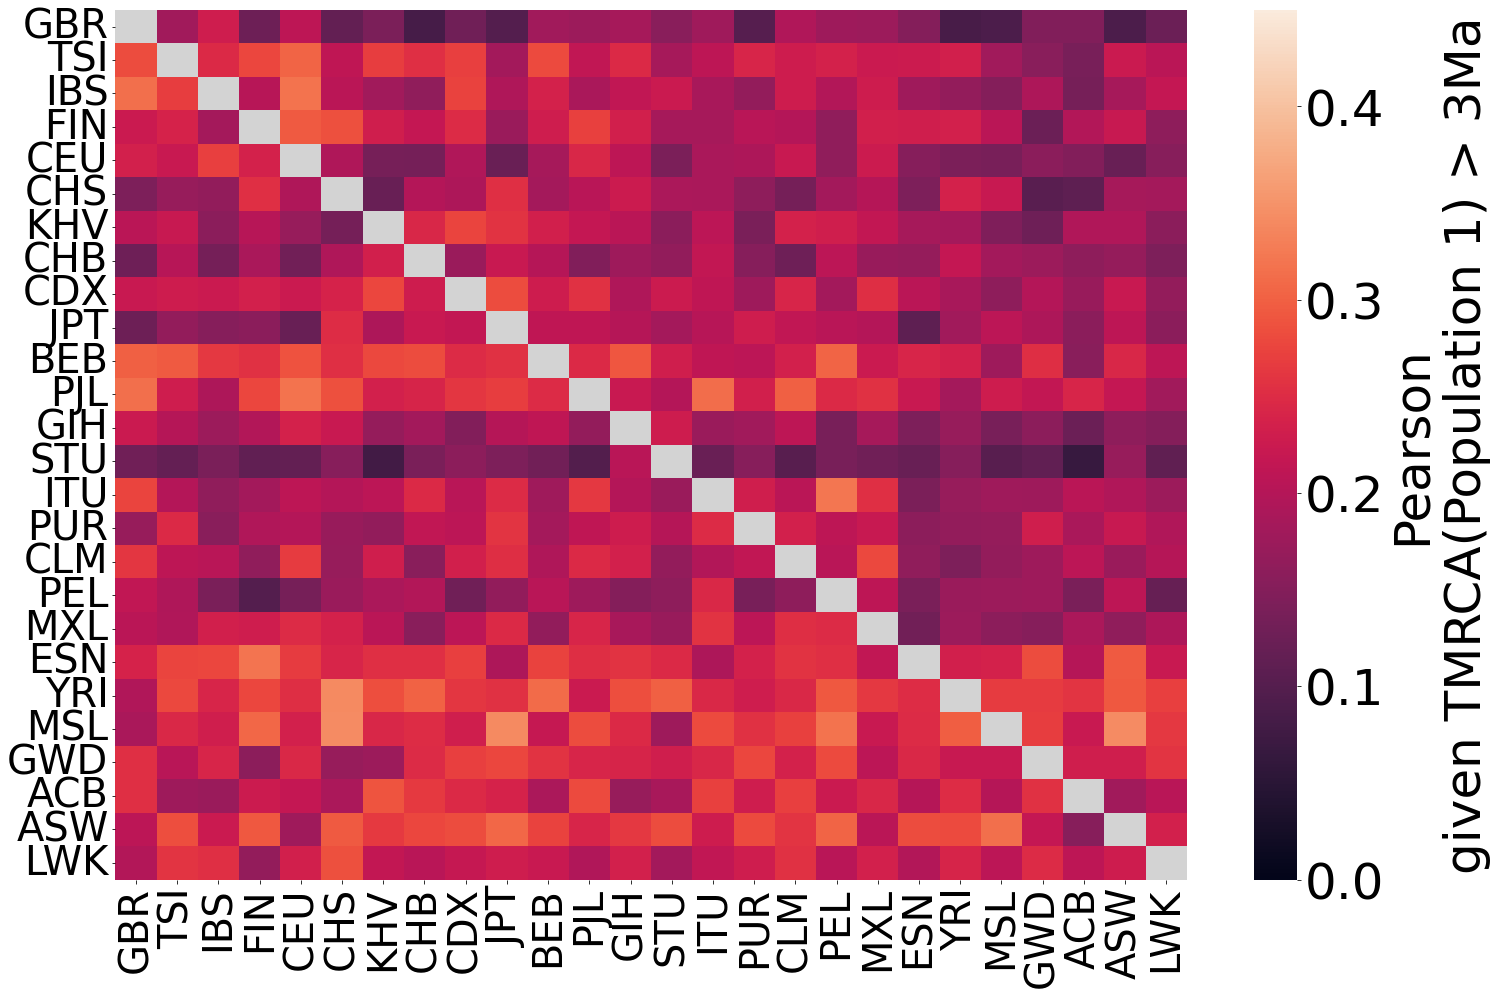

zmintime=4000000.0; cor=pearson;
	0.15835286650816793
	max pval=0.470708656054434


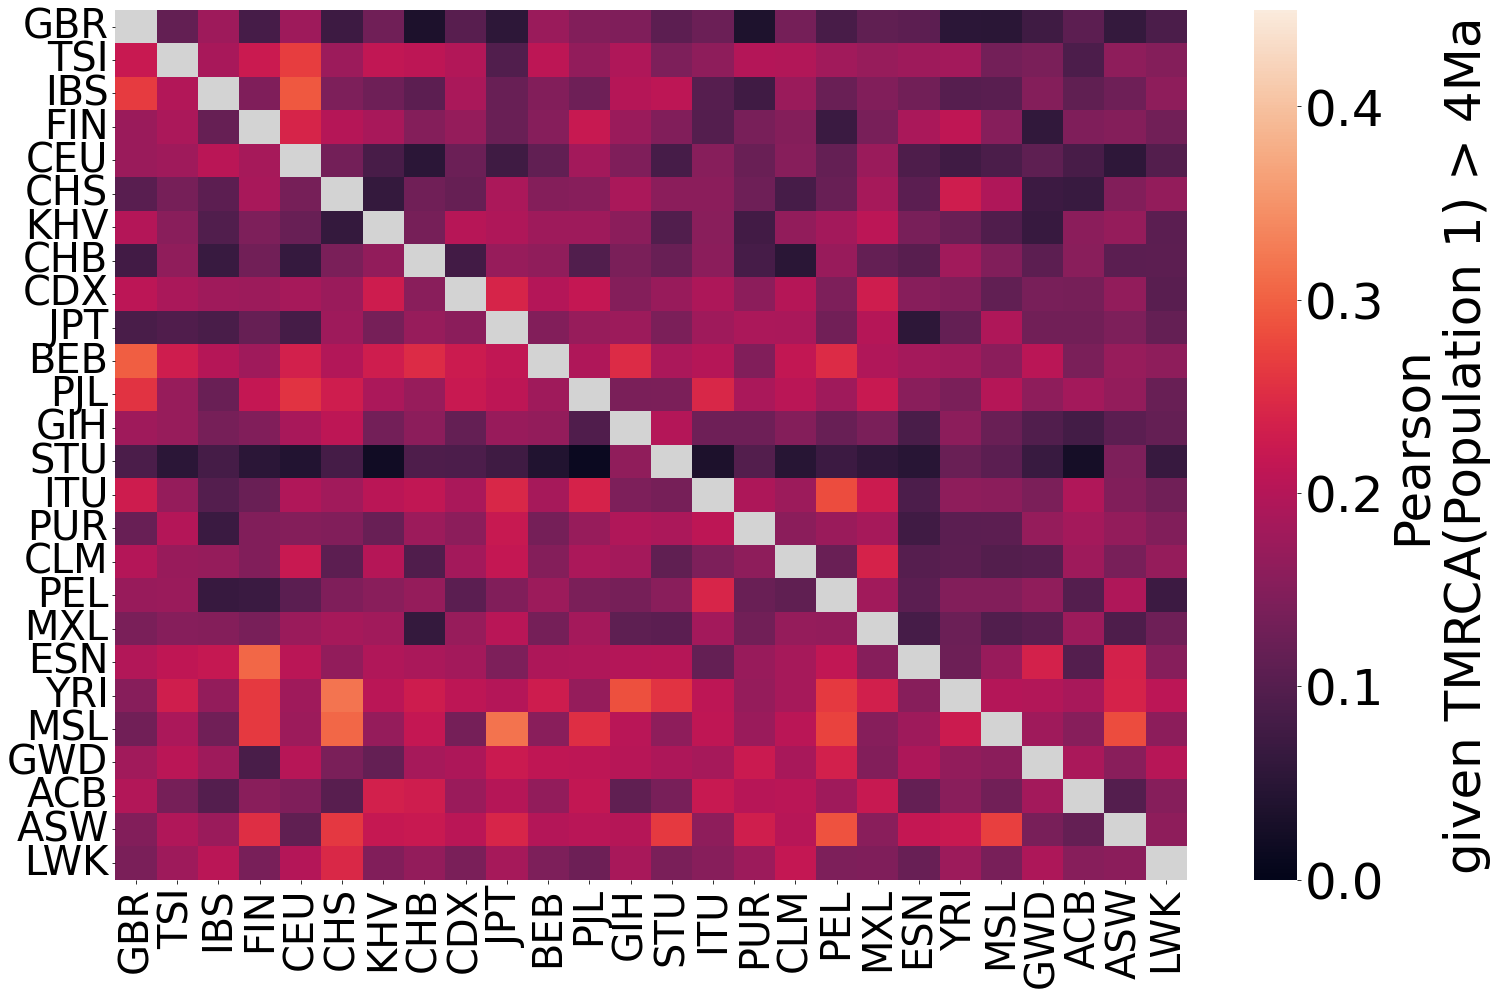

zmintime=5000000.0; cor=pearson;
	0.11317399452304759
	max pval=0.945596066085175


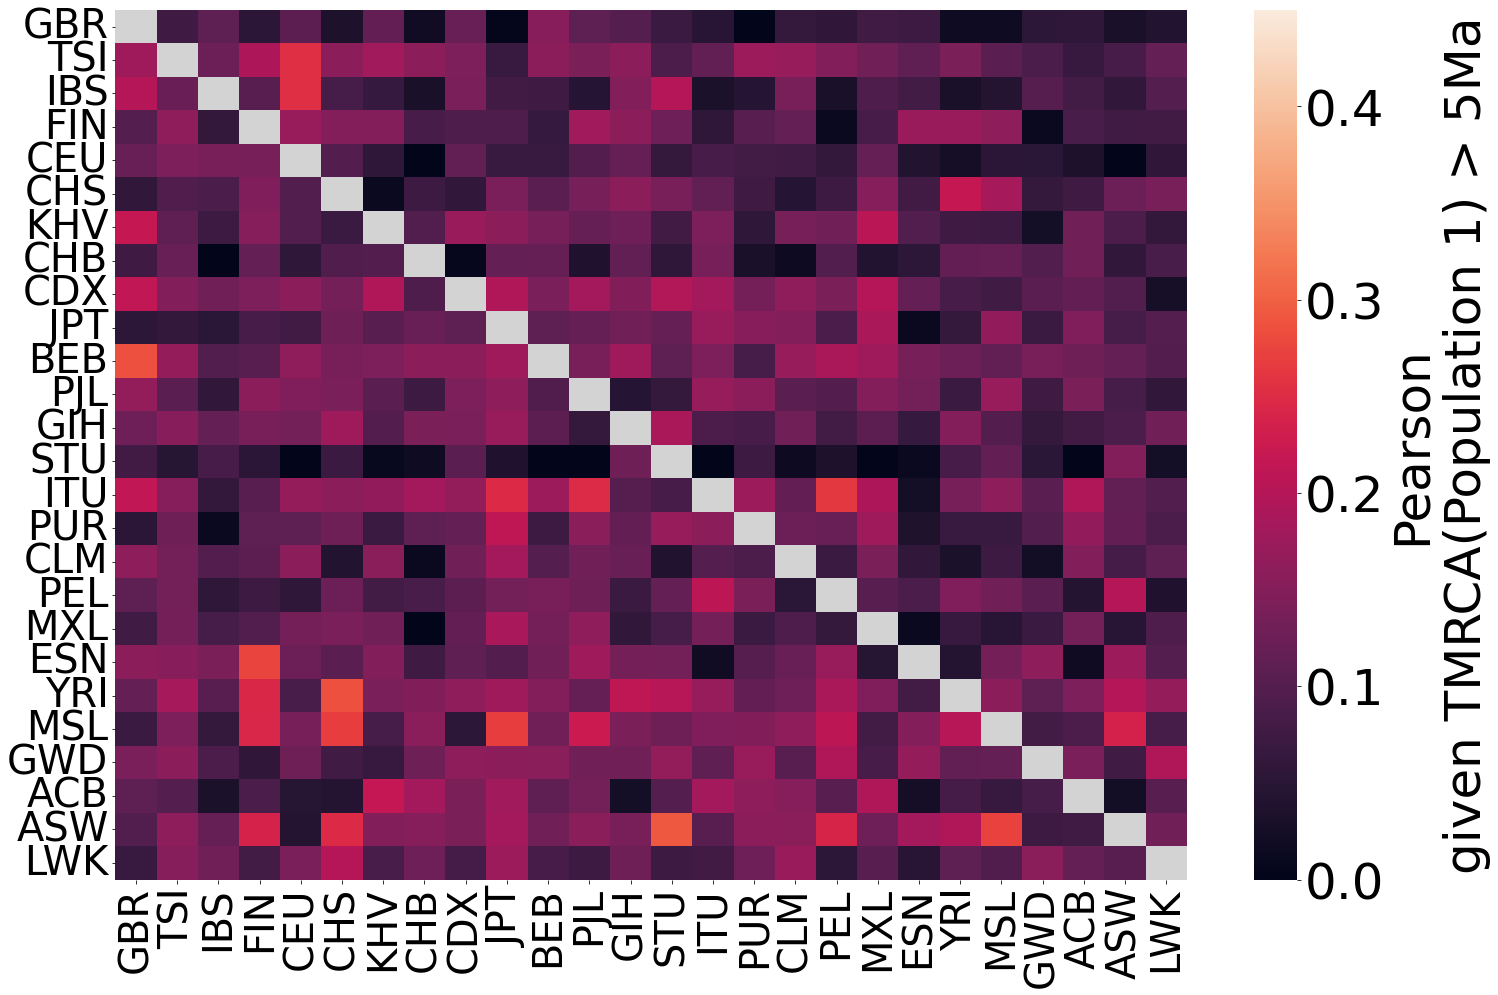

zmintime=6000000.0; cor=pearson;
	0.07862419396992454
	max pval=0.9899017610353302


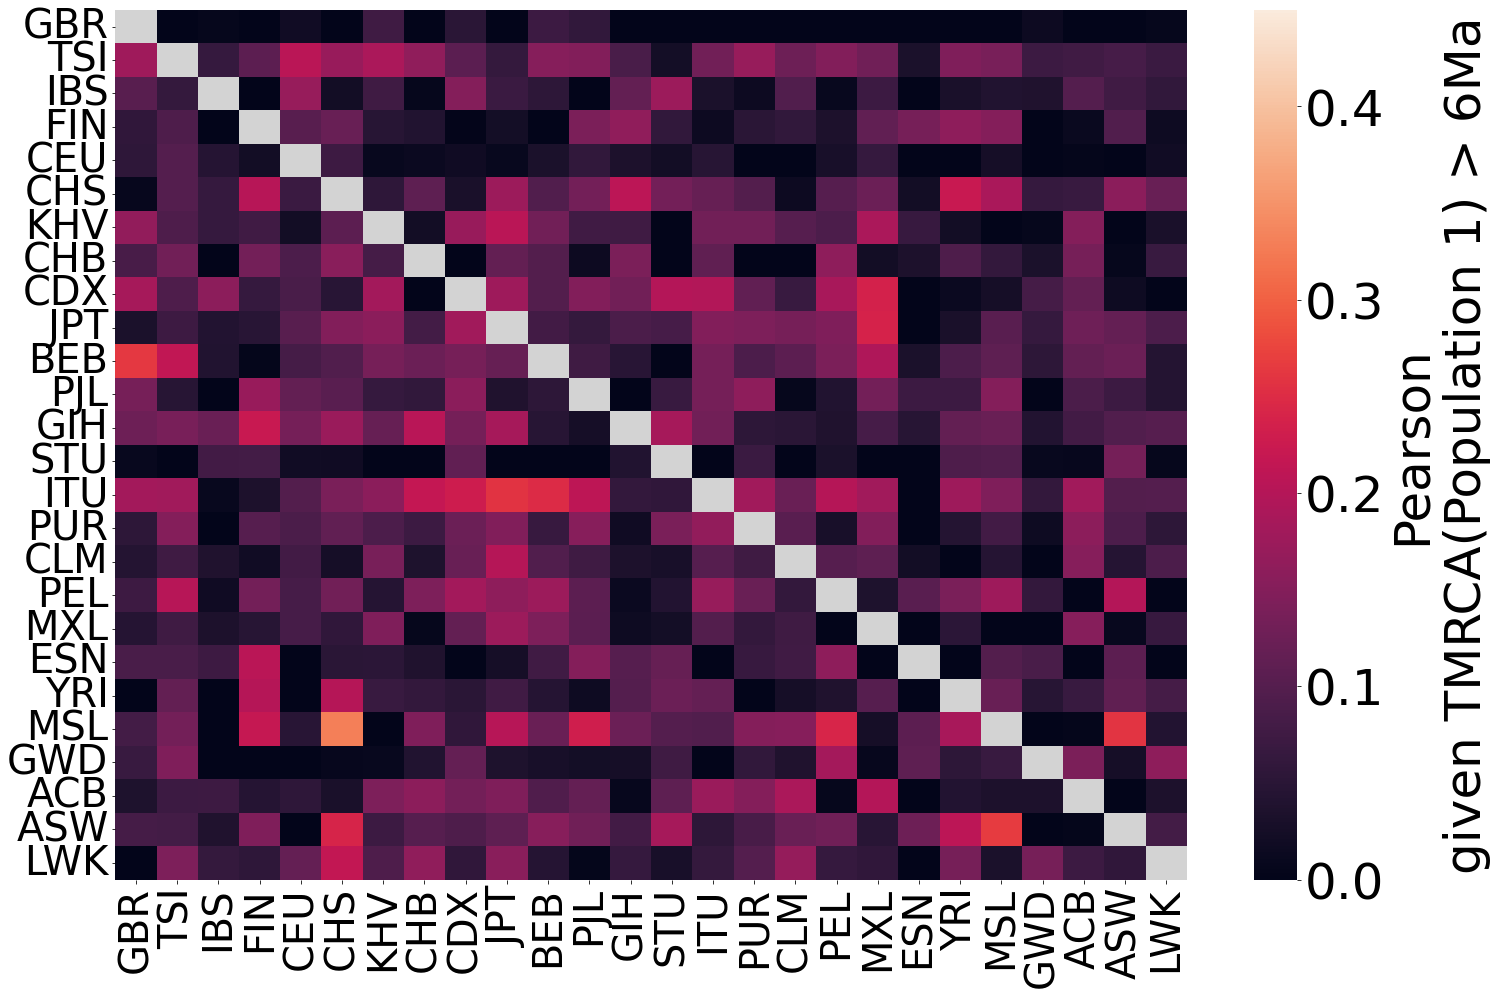

zmintime=1000000.0; cor=spearman;
	0.16078838000241077
	max pval=2.651177741623984e-19


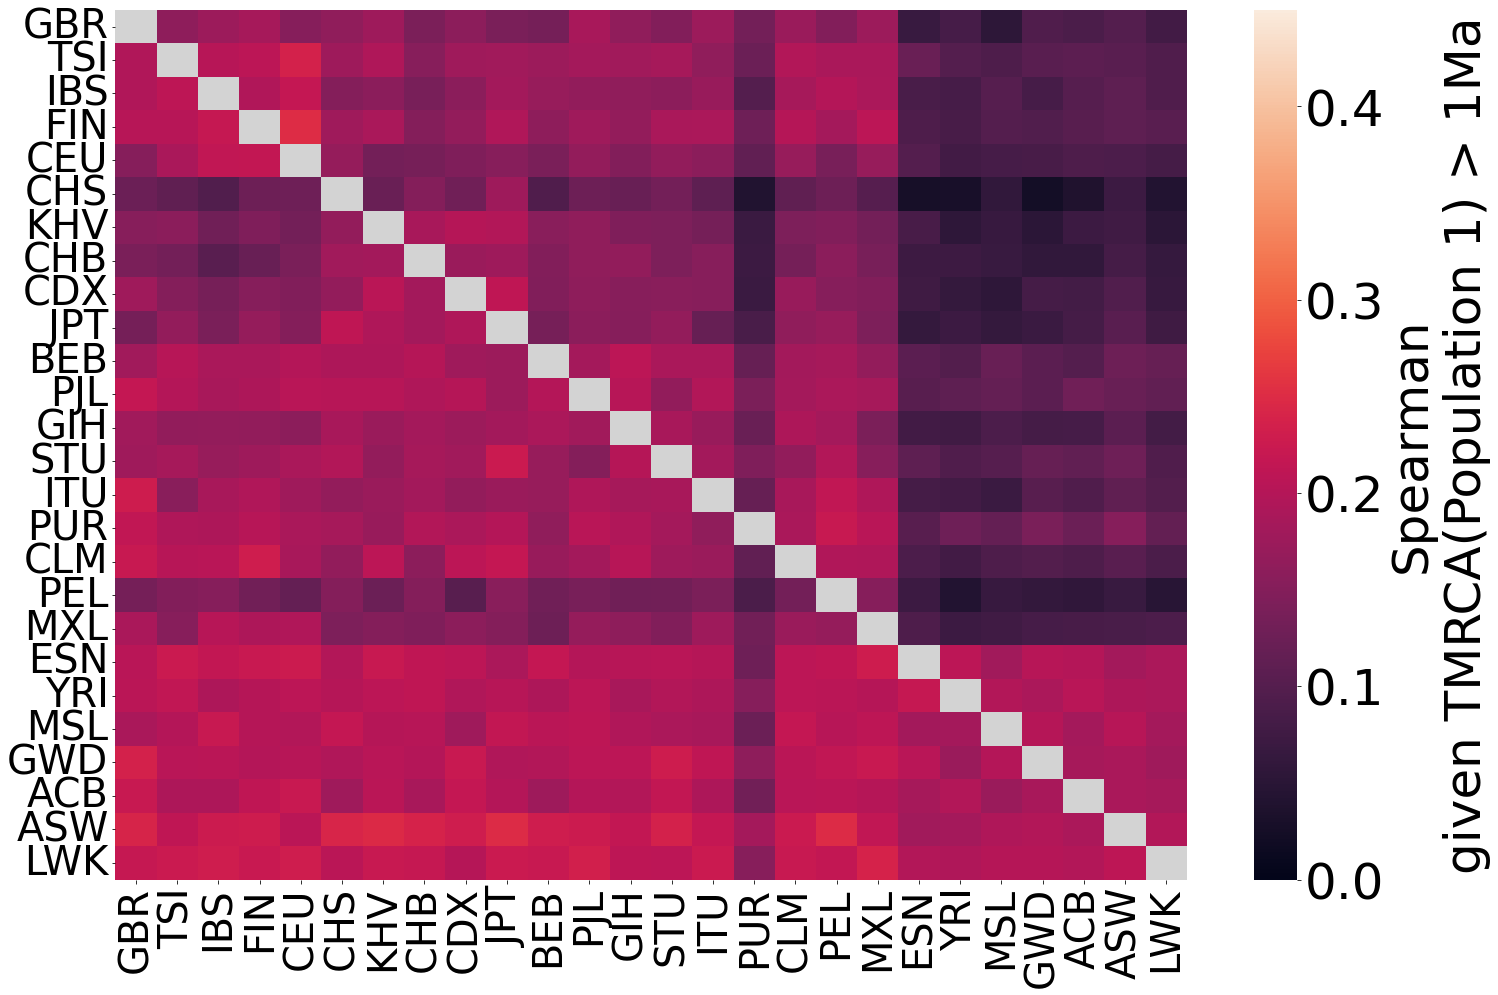

zmintime=2000000.0; cor=spearman;
	0.11821317759914711
	max pval=0.06793311746057473


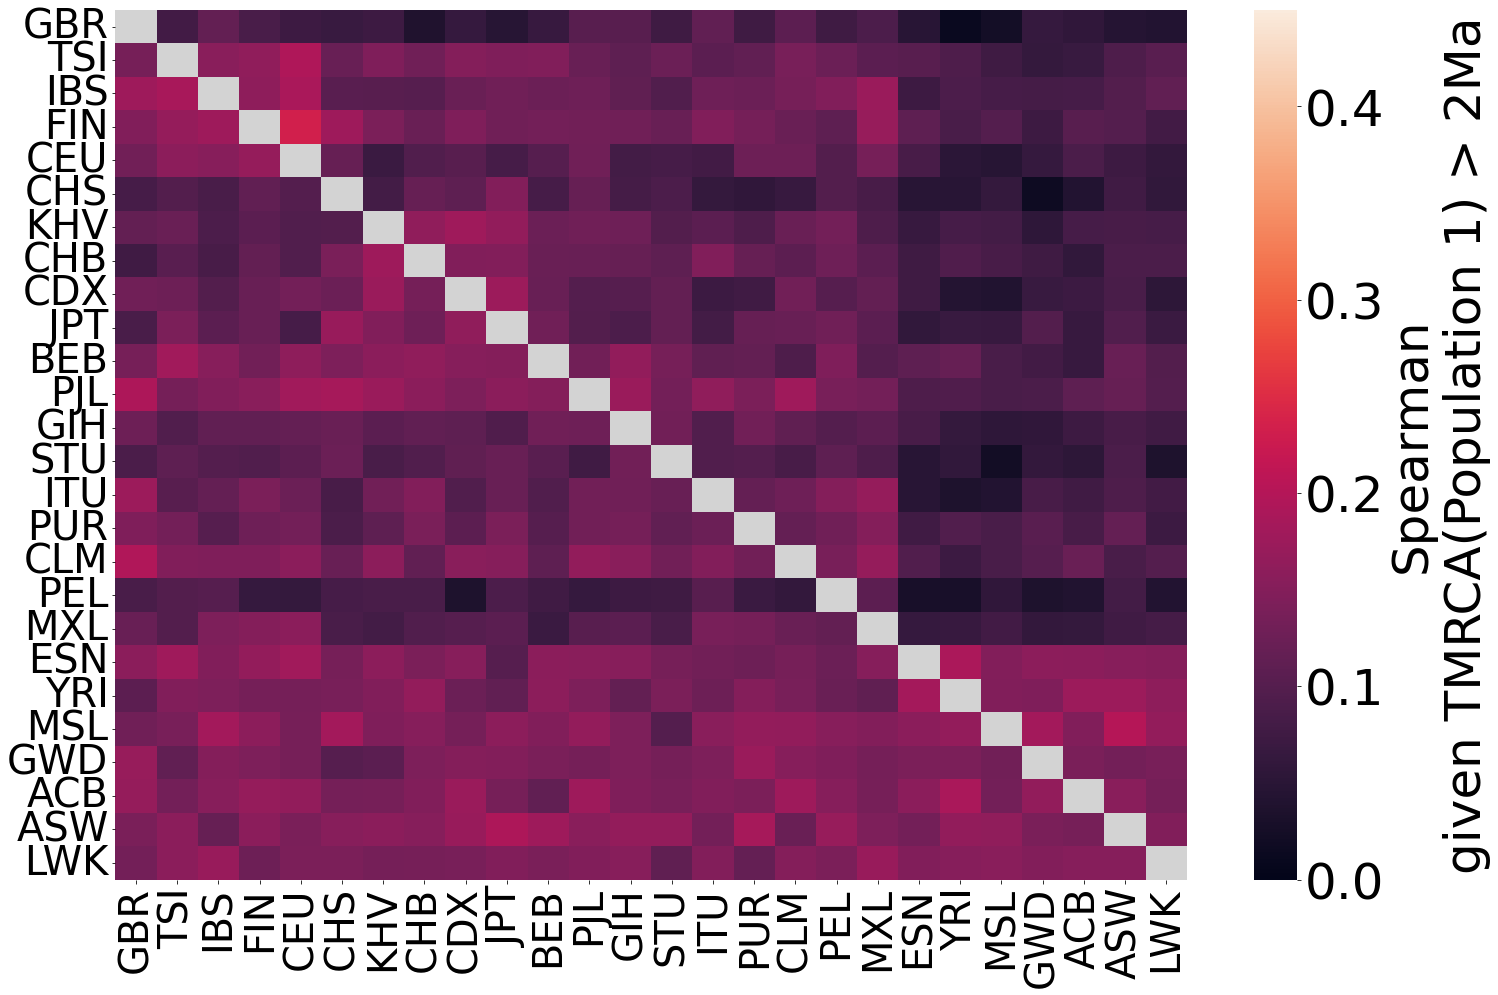

zmintime=3000000.0; cor=spearman;
	0.09837814490159737
	max pval=0.9377288517853574


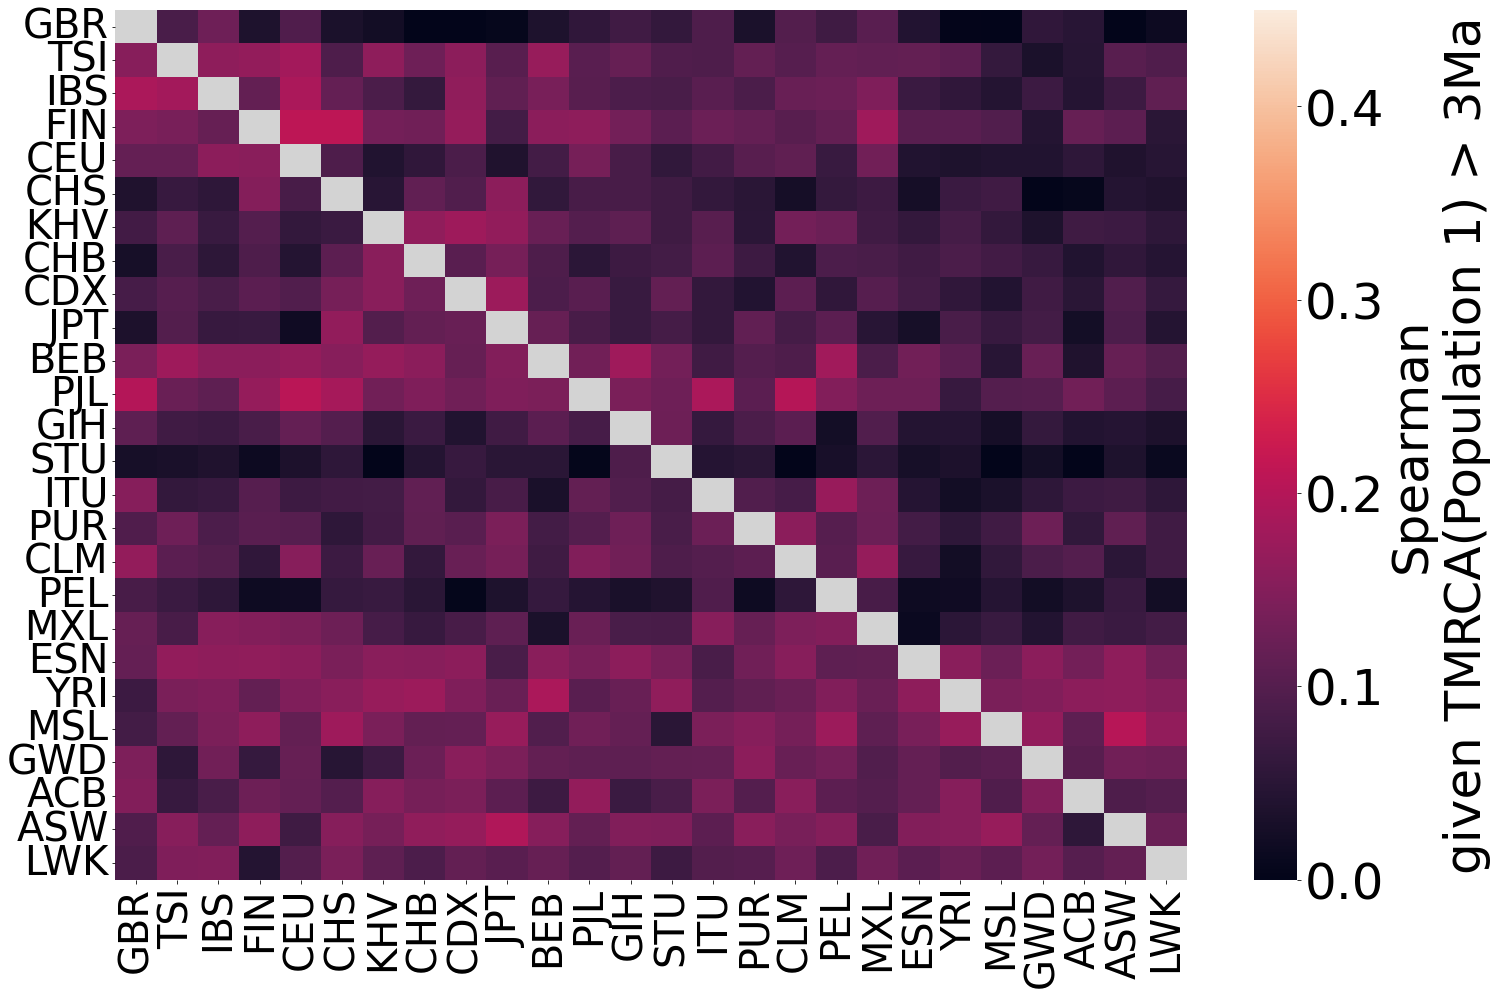

zmintime=4000000.0; cor=spearman;
	0.09208437634714205
	max pval=0.9960126078911651


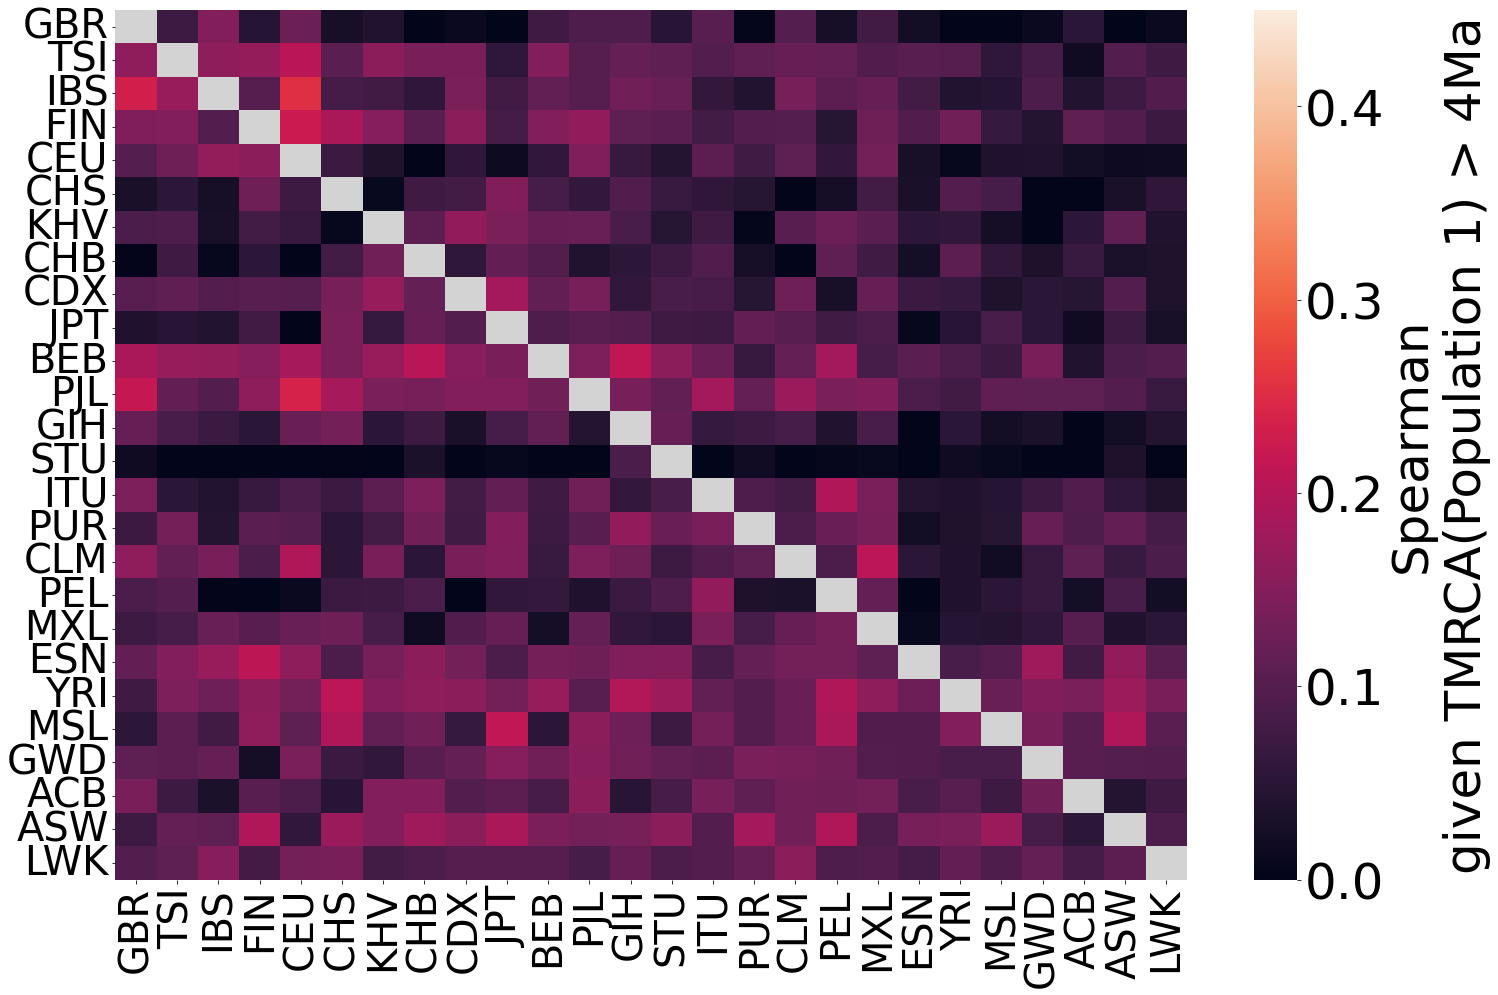

zmintime=5000000.0; cor=spearman;
	0.08230100998888626
	max pval=0.9772694531468584


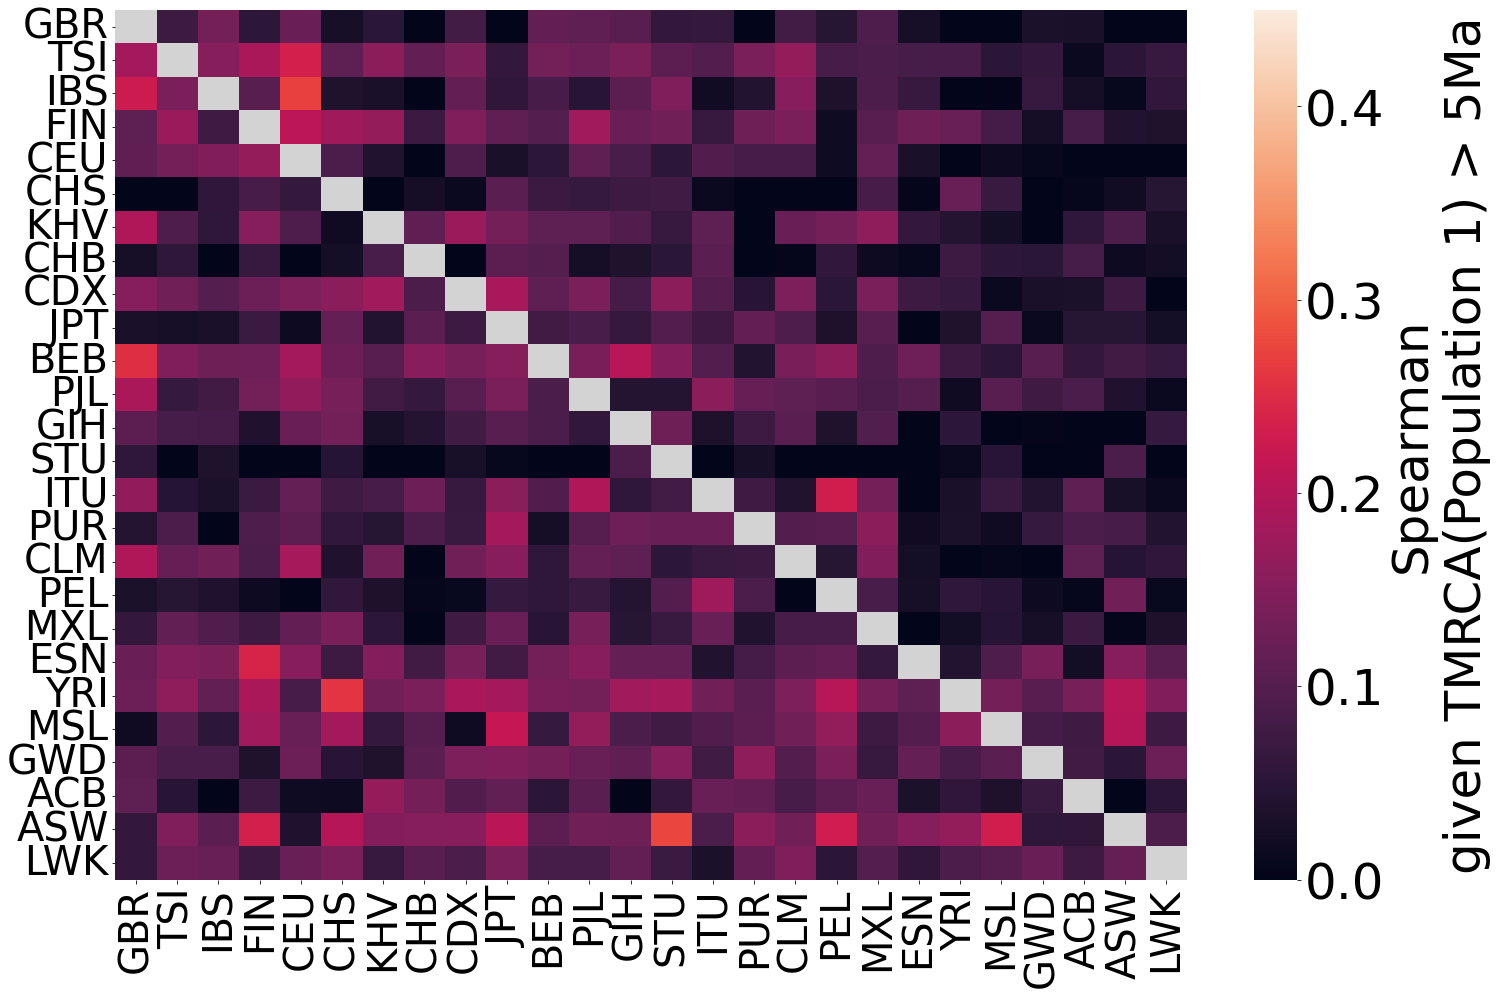

zmintime=6000000.0; cor=spearman;
	0.07625130311908536
	max pval=0.9920486612016601


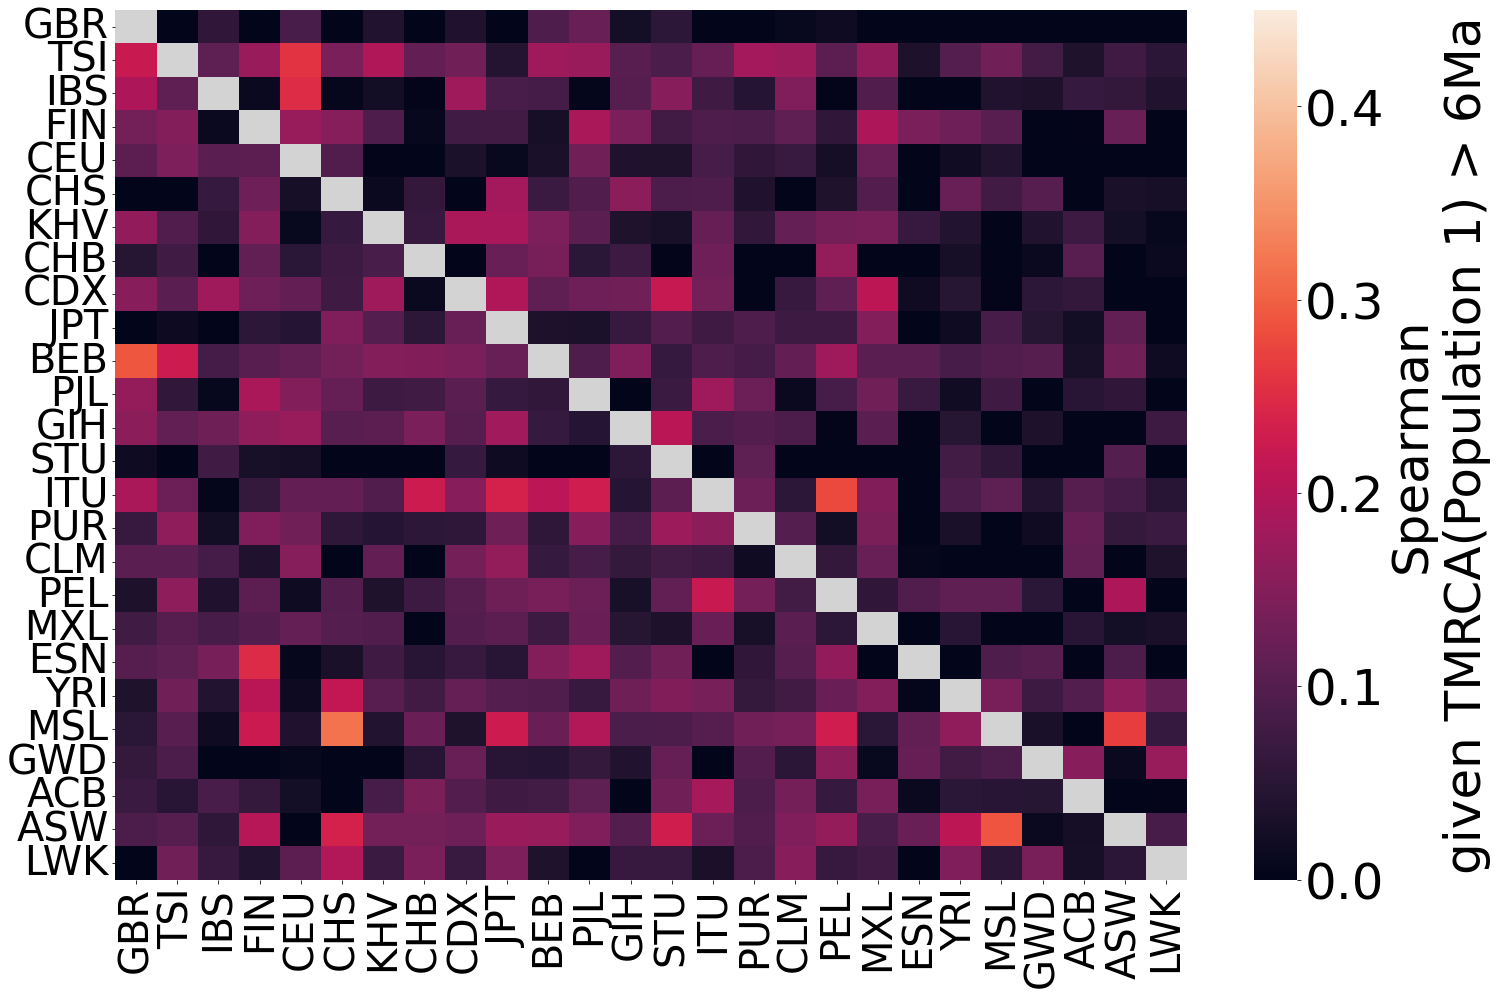

In [64]:
zmin=0
zmax = 0.45
zpops = [i.split('_')[0] for i in pop_and_sample]
cor_label = {'pearson':'Pearson','spearman':'Spearman'}

for cor in ['pearson','spearman']:
    for zmintime in [1e+06,2e+06,3e+06,4e+06,5e+06,6e+06]:
        zmat = matrix_correlations[zmintime][cor]
        mean_cor = zmat[zmat!=0].mean()
        print(f'zmintime={zmintime}; cor={cor};\n\t{mean_cor}')
        
        
        zmatpval = matrix_correlations_pvals[zmintime][cor]
        max_pval = zmatpval.max()
        print(f'\tmax pval={max_pval}')
        
        maskme = zmat==0
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_facecolor("lightgrey")
        ax1 = sns.heatmap(zmat.transpose(),vmin=zmin,vmax=zmax,mask=maskme,cbar_kws={'label':f'{cor_label[cor]}\ngiven TMRCA(Population 1) > {int(zmintime/1000000)}Ma'})
        ax1.set_xticks(np.arange(0,26,1)+0.5,labels=zpops,rotation=90,fontsize=40)
        ax1.set_yticks(np.arange(0,26,1)+0.5,labels=zpops,rotation=0,fontsize=40)
        plot_name = f"plot_correlation_TMRCAs_allpops_Tmin{zmintime}_cor{cor}_240724_2000.pdf"
        plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
        # 
        plt.show()

## Correlation between TMRCAs and other data


In [11]:
# strict mask for GRCh38 /home/tc557/rds/rds-durbin-group-8b3VcZwY7rY/projects/human/HGDP/GRCh38_ref/strict_perchrom


mappability_bed = pybedtools.BedTool("/home/tc557/rds/rds-durbin-group-8b3VcZwY7rY/projects/human/HGDP/GRCh38_ref/strict_perchrom/chr1.bed")


In [12]:
segdup_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/SegmentalDups.gz").intersect(mappability_bed).sort()


In [13]:
# https://genome-euro.ucsc.edu/cgi-bin/hgTrackUi?hgsid=289519827_1mdrzgr4nfcOgfOn0BdLBBFJ6qGI&g=genomicSuperDups&hgTracksConfigPage=configure
# "This track shows regions detected as putative genomic duplications within the golden path"


segdup_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/SegmentalDups.gz").intersect(mappability_bed).sort()

# https://genome-euro.ucsc.edu/cgi-bin/hgTrackUi?hgsid=289519827_1mdrzgr4nfcOgfOn0BdLBBFJ6qGI&g=rmsk&hgTracksConfigPage=configure
repeat_masked_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/RepeatMasker.bed.gz").intersect(mappability_bed).sort()

WindowMaskerSDust_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/WindowMaskerSDust.gz").intersect(mappability_bed).sort()
SimpleRepeats_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/SimpleRepeats.gz").intersect(mappability_bed).sort()
SelfChain_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/SelfChain.gz").intersect(mappability_bed).sort()
Microsatellite_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/Microsatellite.gz").intersect(mappability_bed).sort()
InterruptedRepeats_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/InterruptedRepeats.gz").intersect(mappability_bed).sort()

# https://genome-euro.ucsc.edu/cgi-bin/hgTrackUi?hgsid=289519827_1mdrzgr4nfcOgfOn0BdLBBFJ6qGI&g=cons100way&hgTracksConfigPage=configure
conserved_vert_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/ConservationVertebrates.gz").intersect(mappability_bed).sort()
conserved_mamm_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/ConservationPlacentalMammals.gz").intersect(mappability_bed).sort()
conserved_prim_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/ConservationPrimates.gz").intersect(mappability_bed).sort()

CpGIslands_bed = pybedtools.BedTool("/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/CpGIslands.gz").intersect(mappability_bed).sort()



In [14]:
codingsequence_bed = pd.read_csv("/home/tc557/rds/hpc-work/gencode_hg20/havana_CDS_proteincoding_chr1_sortednonoverlapping.bed.gz",header=None,names=['chrom','type','start','end'],sep=' ')

In [15]:
def bed_to_seq(bed):
    length_intervals = len(bed)
    length_seq = int(bed[length_intervals-1][2])
    seq = np.zeros(length_seq)
    for i in bed:
       seq[int(i[1]):int(i[2])] = 1 
    return seq

def bed_df_to_seq(bed):
    length_intervals = len(bed)
    length_seq = np.array(bed['end'])[-1]
    seq = np.zeros(length_seq)
    
    for i in range(0,len(bed)):
        start = bed.iloc[i,2]
        end = bed.iloc[i,3]
        seq[start:end] = 1 
    return seq

def tmrcas_to_seq(tmrcas,position):
    step_size = position[1]-position[0]
    length_seq = position[-1]+step_size
    tmrcas_seq = np.zeros(int(length_seq))
    for i,pos in enumerate(position):
        tmrcas_seq[int(i*step_size):int((i+1)*step_size)]=tmrcas[i]
    return tmrcas_seq


def distance_to_cds(X):
    # Invert the array so that 1 becomes 0 and 0 becomes 1 (for distance calculation)
    inverted_X = 1 - X
    
    # Use distance_transform_edt to calculate the distance to the nearest 1
    # The output is an array of the same shape where each element represents
    # the distance to the nearest 1 in the inverted_X
    Y = distance_transform_edt(inverted_X)
    
    return Y

def format_pvalue(pval):
    if pval < 1e-2:  # Use scientific notation for small p-values
        return f"{pval:.2e}"
    else:  # Use standard decimal notation for larger p-values
        return f"{pval:.2g}"
    
def convert_years_to_sci_notation(years):
    if years == 0:
        return "0"
    elif years >= 1e6:
        return f"{years / 1e6:.1f}Ma"
    elif years >= 1e3:
        return f"{years / 1e3:.0f}ka"
    else:
        return str(years)

In [16]:
mappabiltiy_seq = bed_to_seq(mappability_bed)
pass_mappability_indices = np.where(mappabiltiy_seq==1)[0]

In [17]:
segdup_seq = bed_to_seq(segdup_bed)
segdup_seq_passmappability = segdup_seq[pass_mappability_indices]
segdup_fraction = segdup_seq[pass_mappability_indices].sum()/len(pass_mappability_indices)
print(f'fraction of callable genome in segdups = {100*segdup_fraction}')

fraction of callable genome in segdups = 1.1441941504745017


In [18]:
repeatmask_seq = bed_to_seq(repeat_masked_bed)
repeatmask_seq_passmappability = repeatmask_seq[pass_mappability_indices]
repeatmask_fraction = repeatmask_seq[pass_mappability_indices].sum()/len(pass_mappability_indices)
print(f'fraction of callable genome in repeats = {100*repeatmask_fraction}')

fraction of callable genome in repeats = 42.75421680071595


In [19]:
CpGIslands_seq = bed_to_seq(CpGIslands_bed)
pass_mappability_indicesz = pass_mappability_indices[pass_mappability_indices<len(CpGIslands_seq)]
CpGIslands_seq_passmappability = CpGIslands_seq[pass_mappability_indicesz]
CpGIslands_fraction = CpGIslands_seq[pass_mappability_indicesz].sum()/len(pass_mappability_indicesz)
print(f'fraction of callable genome in CpG = {100*CpGIslands_fraction}')

fraction of callable genome in CpG = 0.6989222306292922


In [20]:
codingsequence_seq = bed_df_to_seq(codingsequence_bed)
zpass_mappability_indices = pass_mappability_indices[pass_mappability_indices<len(codingsequence_seq)]

codingsequence_seq_passmappability = codingsequence_seq[zpass_mappability_indices]
codingsequence_fraction = codingsequence_seq[zpass_mappability_indices].sum()/len(zpass_mappability_indices)
print(f'fraction of callable genome in CDS = {100*codingsequence_fraction}')

fraction of callable genome in CDS = 1.747645970791083


In [22]:
distance_to_CDS = distance_to_cds(codingsequence_seq)

In [72]:
minlength = min(len(Bseq),len(distance_to_CDS))
x = distance_to_CDS[0:minlength]
y = Bseq[0:minlength]
pearson_corr, pearson_pvalue = stats.pearsonr(x, y)
# Spearman correlation
spearman_corr, spearman_pvalue = stats.spearmanr(x, y)
# Output results
print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

# plt.yscale('log')

		Pearson correlation: 0.38618289103254605, p-value: 0.0
		Spearman correlation: 0.4339791773729536, p-value: 0.0


In [304]:
# Microsatellite_bed

# pass_mappability_indiceszz = pass_mappability_indices[pass_mappability_indices<len(Microsatellite_bed)]
# Microsatellite_seq = bed_to_seq(Microsatellite_bed)
# Microsatellite_seq_passmappability = Microsatellite_seq[pass_mappability_indiceszz]
# Microsatellite_fraction = Microsatellite_seq[pass_mappability_indiceszz].sum()/len(pass_mappability_indiceszz)
# print(f'fraction of callable genome in Microsatellite = {100*Microsatellite_fraction}')

zpopsam=GBR_HG00118
	=slope = 0.5521069638589818
		Pearson correlation: 0.7282031659641365, p-value: 2.3108291231103653e-06
		Spearman correlation: 0.7780018462531428, p-value: 1.6015469860235293e-07
zpopsam=JPT_NA18939
	=slope = 0.40659479964434164
		Pearson correlation: 0.4834705511918944, p-value: 0.005059306201750505
		Spearman correlation: 0.5278592375366569, p-value: 0.0019029922986547668
zpopsam=ESN_HG03515
	=slope = 0.5107861578814333
		Pearson correlation: 0.6928359444725969, p-value: 1.1097434647768717e-05
		Spearman correlation: 0.7631964809384163, p-value: 3.7860981693526693e-07


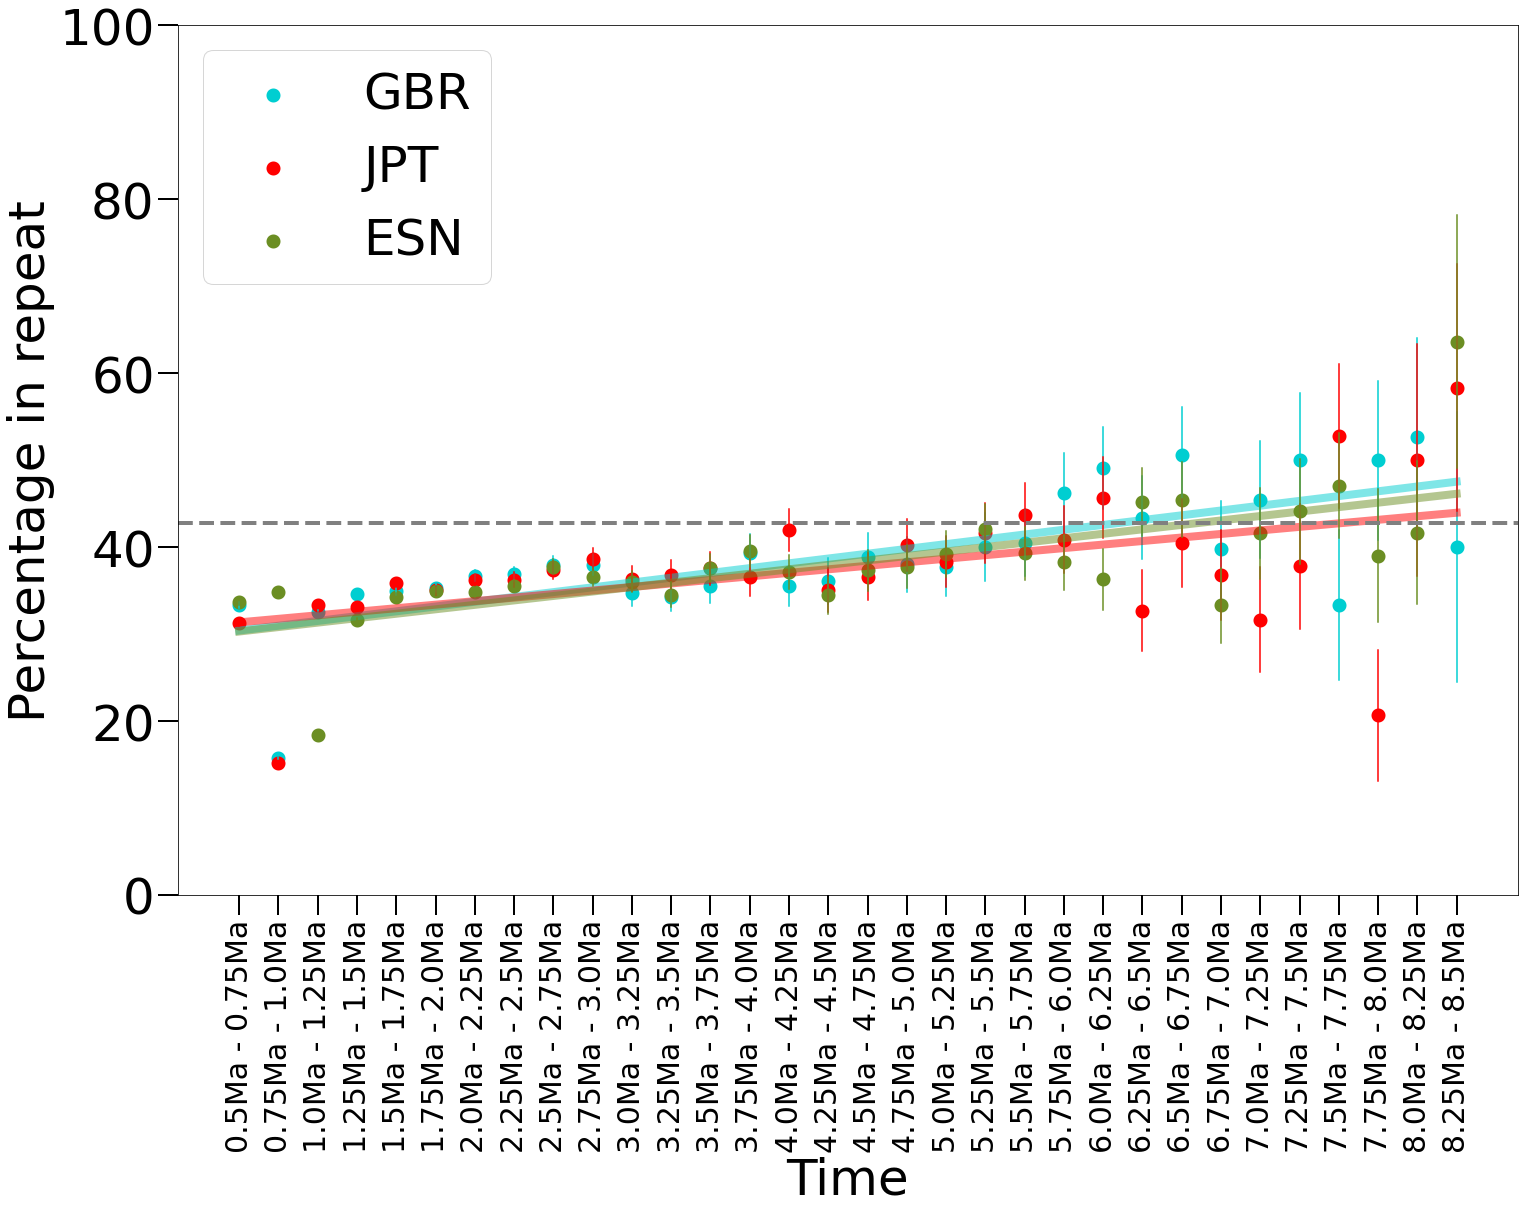

In [23]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    percentage_in_repeat = np.zeros(len(years_stratify)-1)
    standard_errors_in_repeat = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = [i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        repeat_mappability_indices = np.array([i for i in tmrca_indices if repeatmask_seq[i]==1 and mappabiltiy_seq[i]==1])
    #     ztmrcas = tmrcas_seq[repeat_mappability_indices]
        fraction_in_repeat = len(repeat_mappability_indices)/len(tmrca_indices)
        stderrors = np.sqrt((fraction_in_repeat)*(1-fraction_in_repeat)/len(tmrca_indices))
        standard_errors_in_repeat[y] = 100*stderrors
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        percentage_in_repeat[y] = 100*fraction_in_repeat
    plt.scatter(np.arange(0,len(percentage_in_repeat),1),percentage_in_repeat,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(percentage_in_repeat),1),labels=boundaries_xlabs,rotation=90,fontsize=30)
    xz = np.arange(0,len(percentage_in_repeat),1)
    yz = percentage_in_repeat
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
    plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_in_repeat):
        plt.plot((c,c),(percentage_in_repeat[c]-standard_errors_in_repeat[c],percentage_in_repeat[c]+standard_errors_in_repeat[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.axhline(42.75421680071595,linestyle="dashed",color="grey",linewidth=4)
plt.ylabel('Percentage in repeat')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
plt.ylim(0,100)
plt.legend()
plot_name = f"plot_TMRCA_vs_repeats_GBR_YRI_ESN.pdf"
# plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  


In [40]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

mask_threshold= 0.5

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    percentage_in_repeat = np.zeros(len(years_stratify)-1)
    standard_errors_in_repeat = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    
    trimmed_length = len(repeatmask_seq) - (len(repeatmask_seq) % 1000)
    trimmed_array = repeatmask_seq[:trimmed_length]
    # Reshape the array to have 1000 elements in each row
    reshaped_array = trimmed_array.reshape(-1, 1000)
    # Calculate the mean of each row
    repeatmask_seq_means_1kbp = reshaped_array.mean(axis=1)
    
    trimmed_length = len(mappabiltiy_seq) - (len(mappabiltiy_seq) % 1000)
    trimmed_array = mappabiltiy_seq[:trimmed_length]
    # Reshape the array to have 1000 elements in each row
    reshaped_array = trimmed_array.reshape(-1, 1000)
    # Calculate the mean of each row
    mappabiltiy_seq_means_1kbp = reshaped_array.mean(axis=1)
    
    zindices = np.where(mappabiltiy_seq_means_1kbp>mask_threshold)[0]
    minlength = min(len(tmrcas_seq)//1000-1,len(repeatmask_seq_means_1kbp)-1)
    zindices = zindices[zindices<minlength]
    zx = tmrcas_seq[zindices*1000][::10]
    zy = repeatmask_seq_means_1kbp[zindices][::10]
    
    
    pearson_corr, pearson_pvalue = stats.pearsonr(zx, zy)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(zx, zy)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")



zpopsam=GBR_HG00118
		Pearson correlation: 0.018644995053862242, p-value: 0.009251369532983316
		Spearman correlation: 0.010303131058354592, p-value: 0.15040299544220317
zpopsam=JPT_NA18939
		Pearson correlation: 0.01397012667823786, p-value: 0.05118309026501056
		Spearman correlation: -0.0004311084113000328, p-value: 0.9520195156340999
zpopsam=ESN_HG03515
		Pearson correlation: 0.03137849654521613, p-value: 1.1826162418899095e-05
		Spearman correlation: 0.027212094744056618, p-value: 0.00014536160168229868


zpopsam=GBR_HG00118
	=slope = -0.004405342617416072
		Pearson correlation: -0.05847316358418312, p-value: 0.7505713178961391
		Spearman correlation: -0.04605809252972728, p-value: 0.8023471330538028
zpopsam=JPT_NA18939
	=slope = -0.03320223046276265
		Pearson correlation: -0.5029930734838501, p-value: 0.0033437515556117127
		Spearman correlation: -0.49173005285178945, p-value: 0.004258568831368017
zpopsam=ESN_HG03515
	=slope = 0.04486005078890496
		Pearson correlation: 0.32825758472340305, p-value: 0.06662035027740279
		Spearman correlation: 0.28485015241988343, p-value: 0.11406495642437287


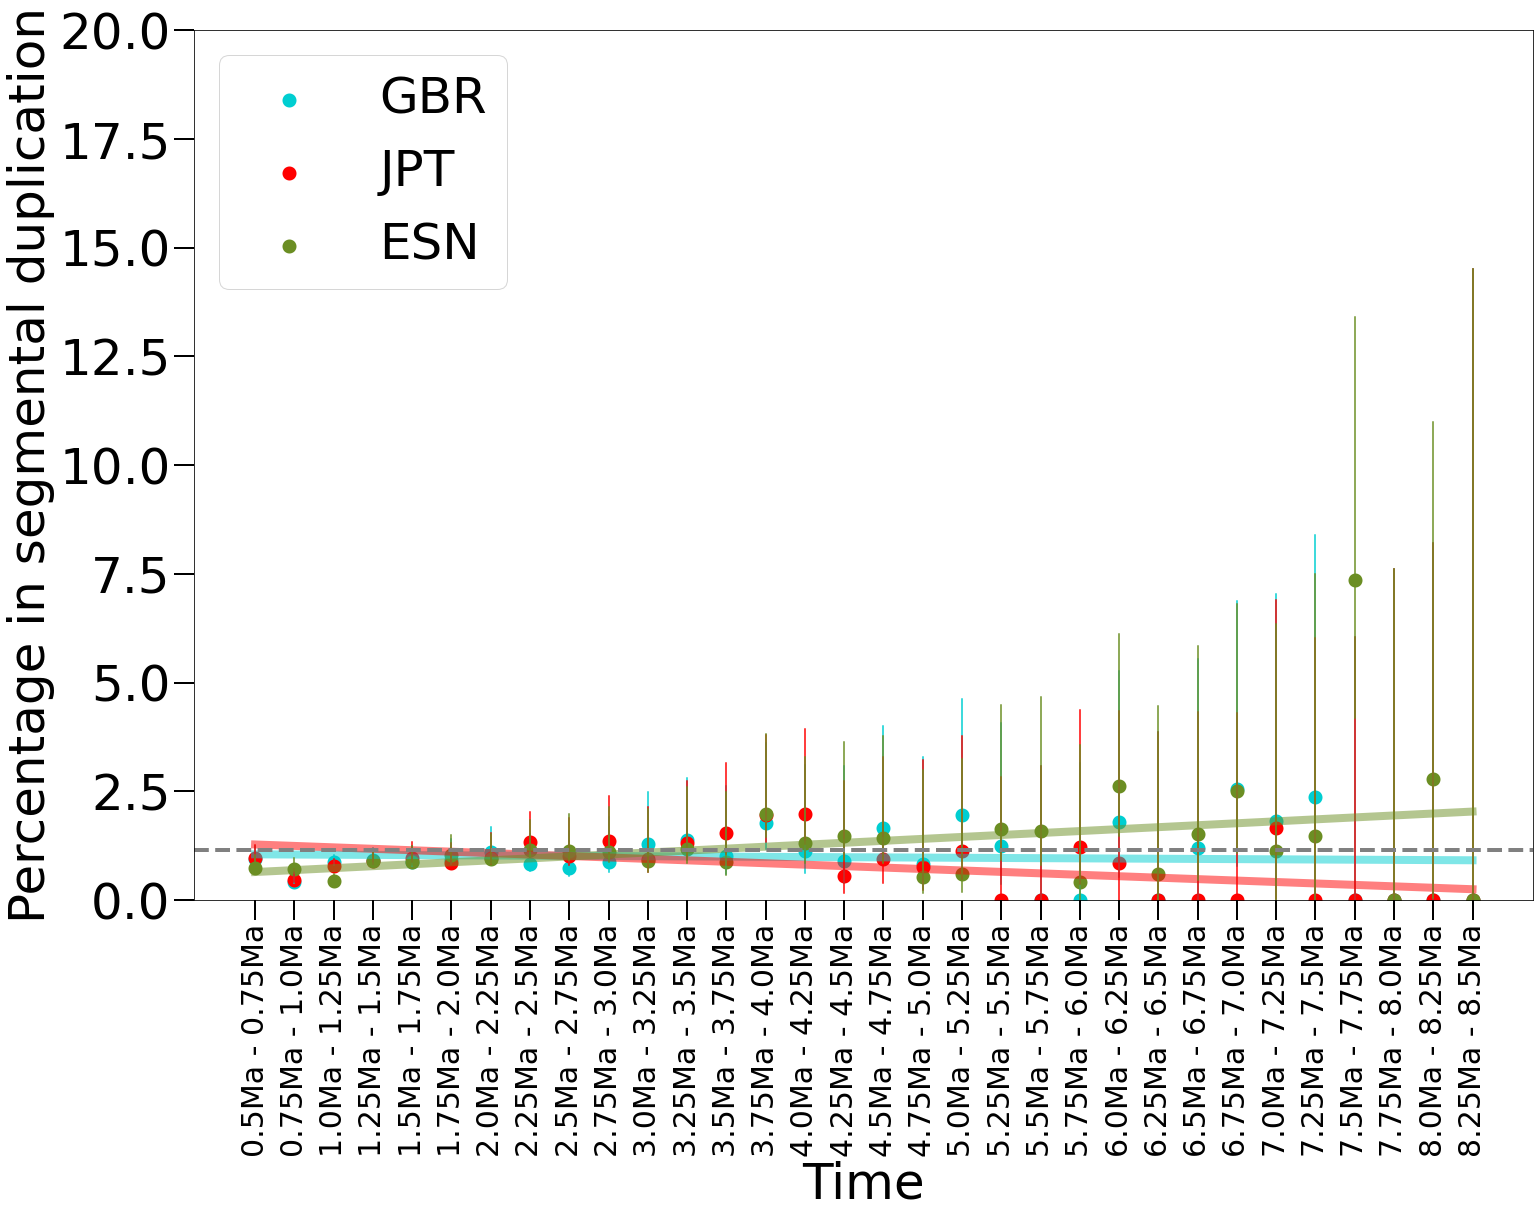

In [25]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    percentage_in_segdup = np.zeros(len(years_stratify)-1)
    standard_errors_in_segdup = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = [i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        segdup_indices = np.array([i for i in tmrca_indices if segdup_seq[i]==1 and mappabiltiy_seq[i]==1])
    #     ztmrcas = tmrcas_seq[segdup_indices]
        fraction_in_segdup = len(segdup_indices)/len(tmrca_indices)
        stderrors = np.sqrt((fraction_in_segdup)*(1-fraction_in_segdup)/len(tmrca_indices))
        standard_errors_in_segdup[y] = 100*stderrors
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        percentage_in_segdup[y] = 100*fraction_in_segdup
    plt.scatter(np.arange(0,len(percentage_in_segdup),1),percentage_in_segdup,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(percentage_in_segdup),1),labels=boundaries_xlabs,rotation=90,fontsize=30)
    
    xz = np.arange(0,len(percentage_in_repeat),1)
    yz = percentage_in_segdup
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
    plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_in_segdup):
        plt.plot((c,c),(percentage_in_segdup[c]-standard_errors_in_segdup[c],percentage_in_segdup[c]+standard_errors_in_repeat[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Percentage in segmental duplication')
plt.tick_params('both', length=20, width=2, which='major')
plt.axhline(1.1441941504745017,linestyle="dashed",color="grey",linewidth=4)
plt.tick_params('both', length=15, width=2, which='minor')
plt.ylim(0,20)
plt.legend()    
plot_name = f"plot_TMRCA_vs_segdups_GBR_YRI_ESN.pdf"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plt.show()

zpopsam=GBR_HG00118
	=slope = -0.010017201898355305
		Pearson correlation: -0.2605552863594743, p-value: 0.14978345247804872
		Spearman correlation: -0.4704026390144103, p-value: 0.006589195230240283
zpopsam=IBS_HG01783
	=slope = -0.015357335357213167
		Pearson correlation: -0.4544846323538735, p-value: 0.008970448495990909
		Spearman correlation: -0.597625576263322, p-value: 0.0003041494001965101
zpopsam=CEU_NA12718
	=slope = -0.015354371752505197
		Pearson correlation: -0.4669054530043561, p-value: 0.0070599638567993206
		Spearman correlation: -0.5267237187054754, p-value: 0.0019544321586156626
zpopsam=KHV_HG02113
	=slope = -0.0036278541641130194
		Pearson correlation: -0.07267616906349506, p-value: 0.6926324175278838
		Spearman correlation: -0.30712765751731624, p-value: 0.08729228049970958
zpopsam=CDX_HG02373
	=slope = -0.0034499631040448434
		Pearson correlation: -0.060890009723662, p-value: 0.740607331035563
		Spearman correlation: -0.34376434807617534, p-value: 0.054050984953382

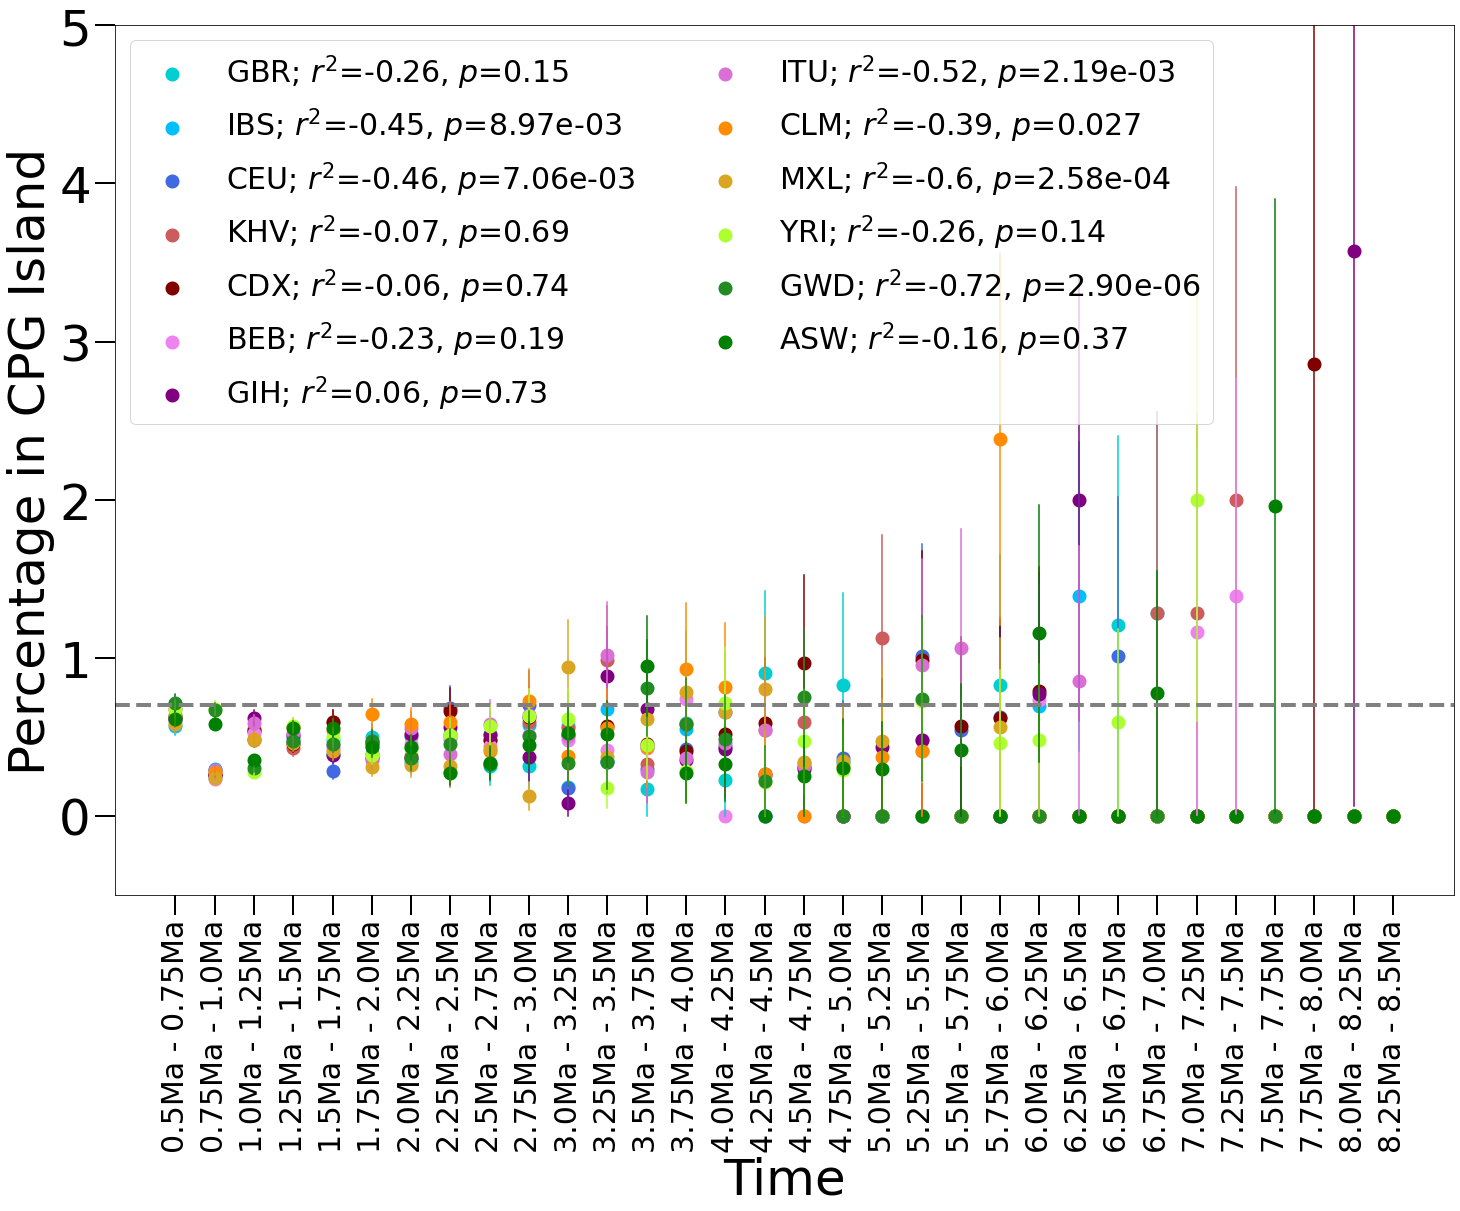

In [43]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)
# years_stratify = np.arange(5e+05,4e+06,1e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

# for zpopsam in pop_and_sample_ofinterest:
for zpopsam in pop_and_sample[::2]:
    print(f'zpopsam={zpopsam}')
    percentage_in_CpGIslands = np.zeros(len(years_stratify)-1)
    standard_errors_in_CpGIslands = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<len(CpGIslands_seq)]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        CpGIslands_indices = np.array([i for i in tmrca_indices if CpGIslands_seq[i]==1 and mappabiltiy_seq[i]==1])
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        fraction_in_CpGIslands = len(CpGIslands_indices)/len(tmrca_indices)
        stderrors = np.sqrt((fraction_in_CpGIslands)*(1-fraction_in_CpGIslands)/len(tmrca_indices))
        standard_errors_in_CpGIslands[y] = 100*stderrors
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        percentage_in_CpGIslands[y] = 100*fraction_in_CpGIslands
    plt.scatter(np.arange(0,len(percentage_in_CpGIslands),1),percentage_in_CpGIslands,linewidth=8,color=pop_colors[zpop],label='')
    plt.xticks(ticks=np.arange(0,len(percentage_in_CpGIslands),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(percentage_in_CpGIslands),1)
    yz = percentage_in_CpGIslands
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
#     plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    zpearsonc = int(100*pearson_corr)/100
    zpval = format_pvalue(pearson_pvalue)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_in_CpGIslands):
        if c==0:
            zlab = f'{zpop}; $r^2$={zpearsonc}, $p$={zpval}'
            plt.scatter(1,10,color=pop_colors[zpop],label=zlab,linewidth=8)
        else:
            zlab=''
        zlabb = ''
        plt.plot((c,c),(percentage_in_CpGIslands[c]-standard_errors_in_CpGIslands[c],percentage_in_CpGIslands[c]+standard_errors_in_CpGIslands[c]),color=pop_colors[zpop],label=zlabb)
plt.xlabel('Time')
plt.ylabel('Percentage in CPG Island')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
plt.ylim(-0.5,5)
plt.axhline(0.6989222306292922,linestyle="dashed",color="grey",linewidth=4)
plt.legend(fontsize=30,ncol=2,loc="upper left")  
plot_name = f"plot_correlation_CpG_TMRCA"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plt.show()

In [130]:
distance_to_CDS[zpass_mappability_indices].mean()

112549.2745621444

zpopsam=GBR_HG00118
	=slope = 7143.6501170212405
		Pearson correlation: 0.6303432407789529, p-value: 0.00011032262374807843
		Spearman correlation: 0.68841642228739, p-value: 1.3295917869209362e-05
zpopsam=JPT_NA18939
	=slope = 6697.046248711585
		Pearson correlation: 0.6750701107241821, p-value: 2.253000543175381e-05
		Spearman correlation: 0.7558651026392962, p-value: 5.668318447006477e-07
zpopsam=ESN_HG03515
	=slope = 5888.4819187014855
		Pearson correlation: 0.8327340643450247, p-value: 3.3965752291308324e-09
		Spearman correlation: 0.9255865102639295, p-value: 3.4223276529301574e-14


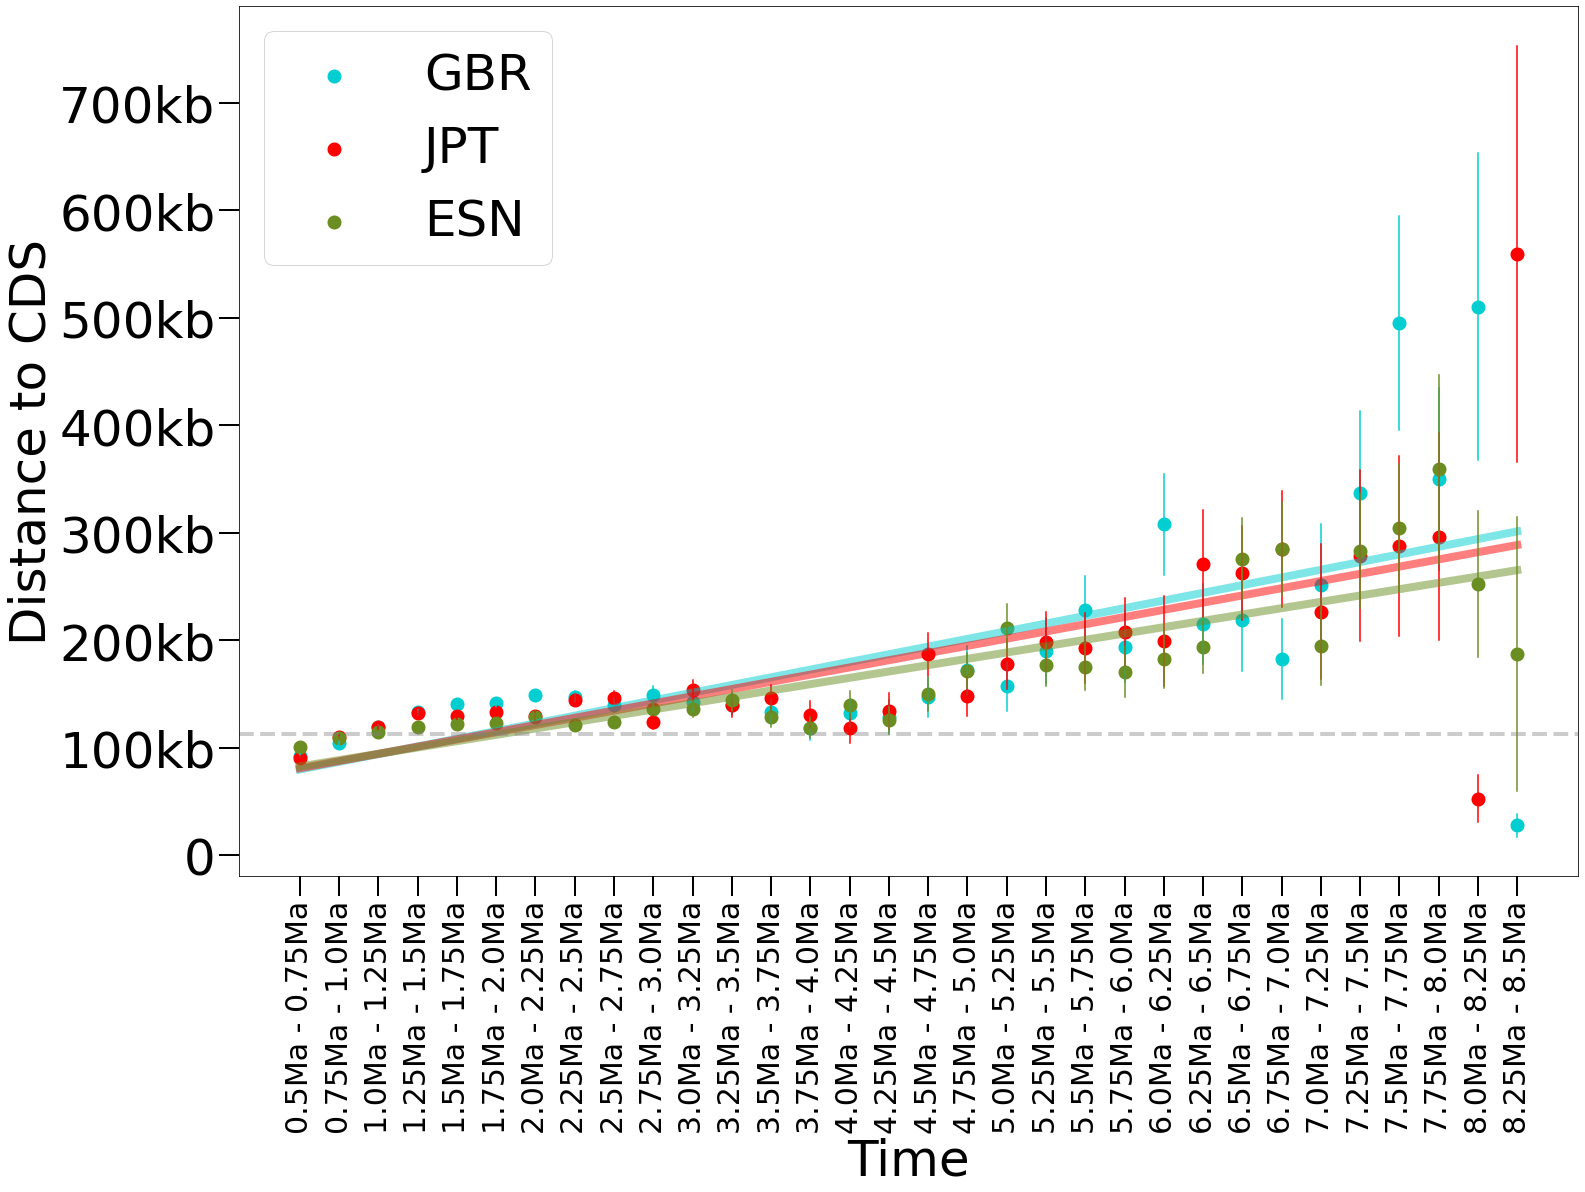

In [76]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    mean_disttoCDS = np.zeros(len(years_stratify)-1)
    standard_errors_disttoCDS = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<len(distance_to_CDS)]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        zdistance_to_CDS = np.array([distance_to_CDS[i] for i in tmrca_indices if mappabiltiy_seq[i]==1])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        mean_distance_to_CDS = zdistance_to_CDS.mean()
        zstderror = zdistance_to_CDS.std()/np.sqrt(len(zdistance_to_CDS))
        standard_errors_disttoCDS[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_disttoCDS[y] = mean_distance_to_CDS
    plt.scatter(np.arange(0,len(mean_disttoCDS),1),mean_disttoCDS,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_disttoCDS),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(mean_disttoCDS),1)
    yz = mean_disttoCDS
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
    plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_disttoCDS):
        plt.plot((c,c),(mean_disttoCDS[c]-standard_errors_disttoCDS[c],mean_disttoCDS[c]+standard_errors_disttoCDS[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Distance to CDS')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
# plt.ylim(0,)
plt.legend()    
plt.axhline(distance_to_CDS[zpass_mappability_indices].mean(),linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plt.yticks([0,100000,200000,300000,400000,500000,600000,700000],[0,'100kb','200kb','300kb','400kb','500kb','600kb','700kb']);
plot_name = f"plot_TMRCA_vs_dcCDS.pdf"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  


In [66]:
def bed_df_to_seq(bed):
    length_intervals = len(bed)
    length_seq = np.array(bed['end'])[-1]
    seq = np.zeros(length_seq)
    
    for i in range(0,len(bed)):
        start = bed.iloc[i,2]
        end = bed.iloc[i,3]
        seq[start:end] = 1 
    return seq


In [67]:
Bmap_file = f'/home/tc557/rds/hpc-work/Murphy_Bmap/liftover_hg20/chr1_nomissing_Hg38.bed'
Bmap_df = pd.read_csv(Bmap_file,sep='\t',header=None)
Blength = np.array(Bmap_df[2])[-1]
Bseq = np.ones(Blength)

In [68]:
for c in range(0,len(Bmap_df)):
    Bseq[Bmap_df.iloc[c,1]:Bmap_df.iloc[c,2]] = Bmap_df.iloc[c,3]

zpopsam=GBR_HG00118
	=slope = 0.0017831058309910074
		Pearson correlation: 0.6721094503638484, p-value: 1.342925427105113e-05
		Spearman correlation: 0.6058059587471352, p-value: 0.00014662843404692933
zpopsam=JPT_NA18939
	=slope = 0.001711570978943853
		Pearson correlation: 0.6743648302871477, p-value: 1.2250814693036038e-05
		Spearman correlation: 0.6620320855614973, p-value: 2.0054259505133756e-05
zpopsam=ESN_HG03515
	=slope = 0.002321006447625135
		Pearson correlation: 0.7594486757082146, p-value: 1.9137413606428717e-07
		Spearman correlation: 0.7317035905271199, p-value: 8.80164237029888e-07


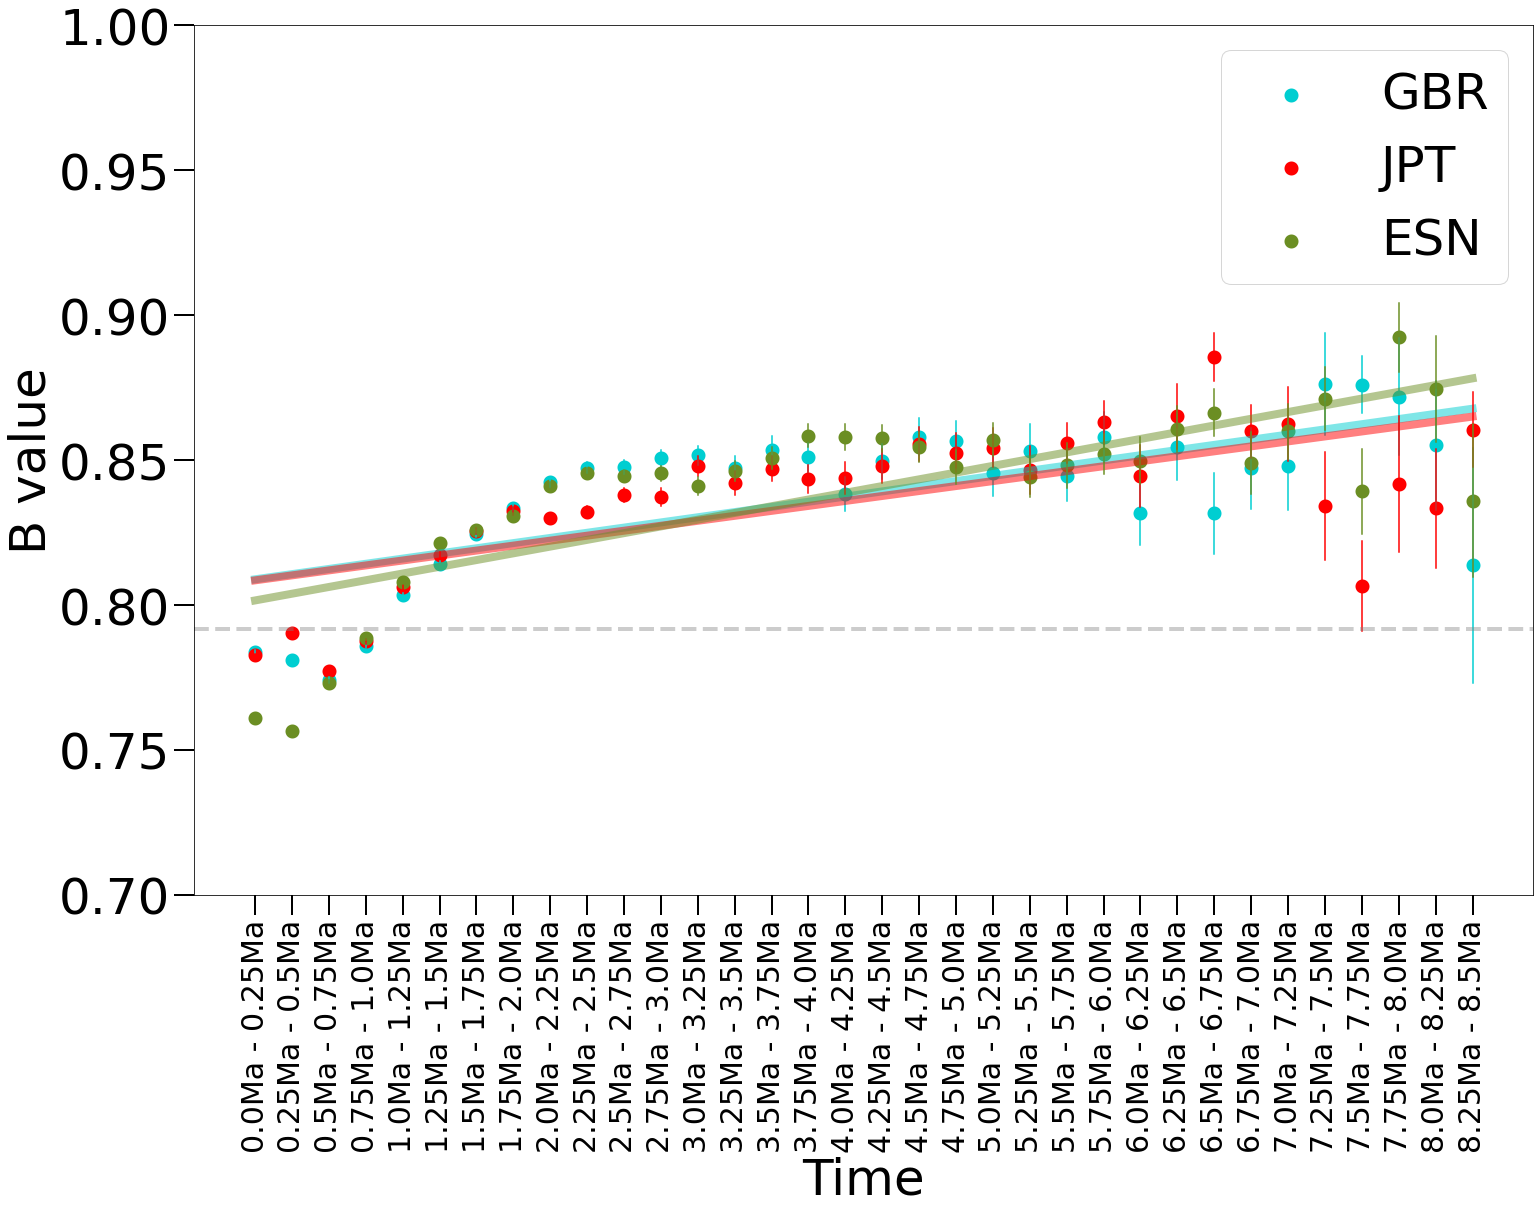

In [75]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(0,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    mean_Bval = np.zeros(len(years_stratify)-1)
    standard_errors_Bval = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<len(distance_to_CDS)]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        zBvalues = np.array([Bseq[i] for i in tmrca_indices if mappabiltiy_seq[i]==1 and Bseq[i]!=1])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        zmean_B = zBvalues.mean()
        zstderror = zBvalues.std()/np.sqrt(len(zBvalues))
        standard_errors_Bval[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_Bval[y] = zmean_B
    plt.scatter(np.arange(0,len(mean_Bval),1),mean_Bval,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_Bval),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(mean_Bval),1)
    yz = mean_Bval
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
    plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_Bval):
        plt.plot((c,c),(mean_Bval[c]-standard_errors_Bval[c],mean_Bval[c]+standard_errors_Bval[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('B value')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
plt.ylim(0.7,1)
plt.legend()    
plt.axhline(Bseq[Bseq!=1].mean(),linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plot_name = f"plot_TMRCA_vs_Bval.pdf"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plt.show()

In [18]:
recombination_map_file = f'/rds/project/rds-8b3VcZwY7rY/users/rs2145/git/fast_psmc/data/ucsc_tracks/genetic_map_hg38_chr1.txt.gz'
recombination_rate_map = msprime.RateMap.read_hapmap(recombination_map_file)

In [20]:
recombination_rate_map.mean_rate

1.1600523082788902e-08

zpopsam=GBR_HG00118
	=slope = -2.474287643370112e-10
		Pearson correlation: -0.5452742535808429, p-value: 0.0012492665940652984
		Spearman correlation: -0.43181818181818177, p-value: 0.013590882949206363
zpopsam=JPT_NA18939
	=slope = -2.412006703410046e-10
		Pearson correlation: -0.482527216630578, p-value: 0.005158481682710646
		Spearman correlation: -0.3654692082111437, p-value: 0.03969397408052556
zpopsam=ESN_HG03515
	=slope = -3.5359856250292543e-10
		Pearson correlation: -0.6948506751510315, p-value: 1.0208993198260034e-05
		Spearman correlation: -0.6612903225806451, p-value: 3.7792302156202e-05


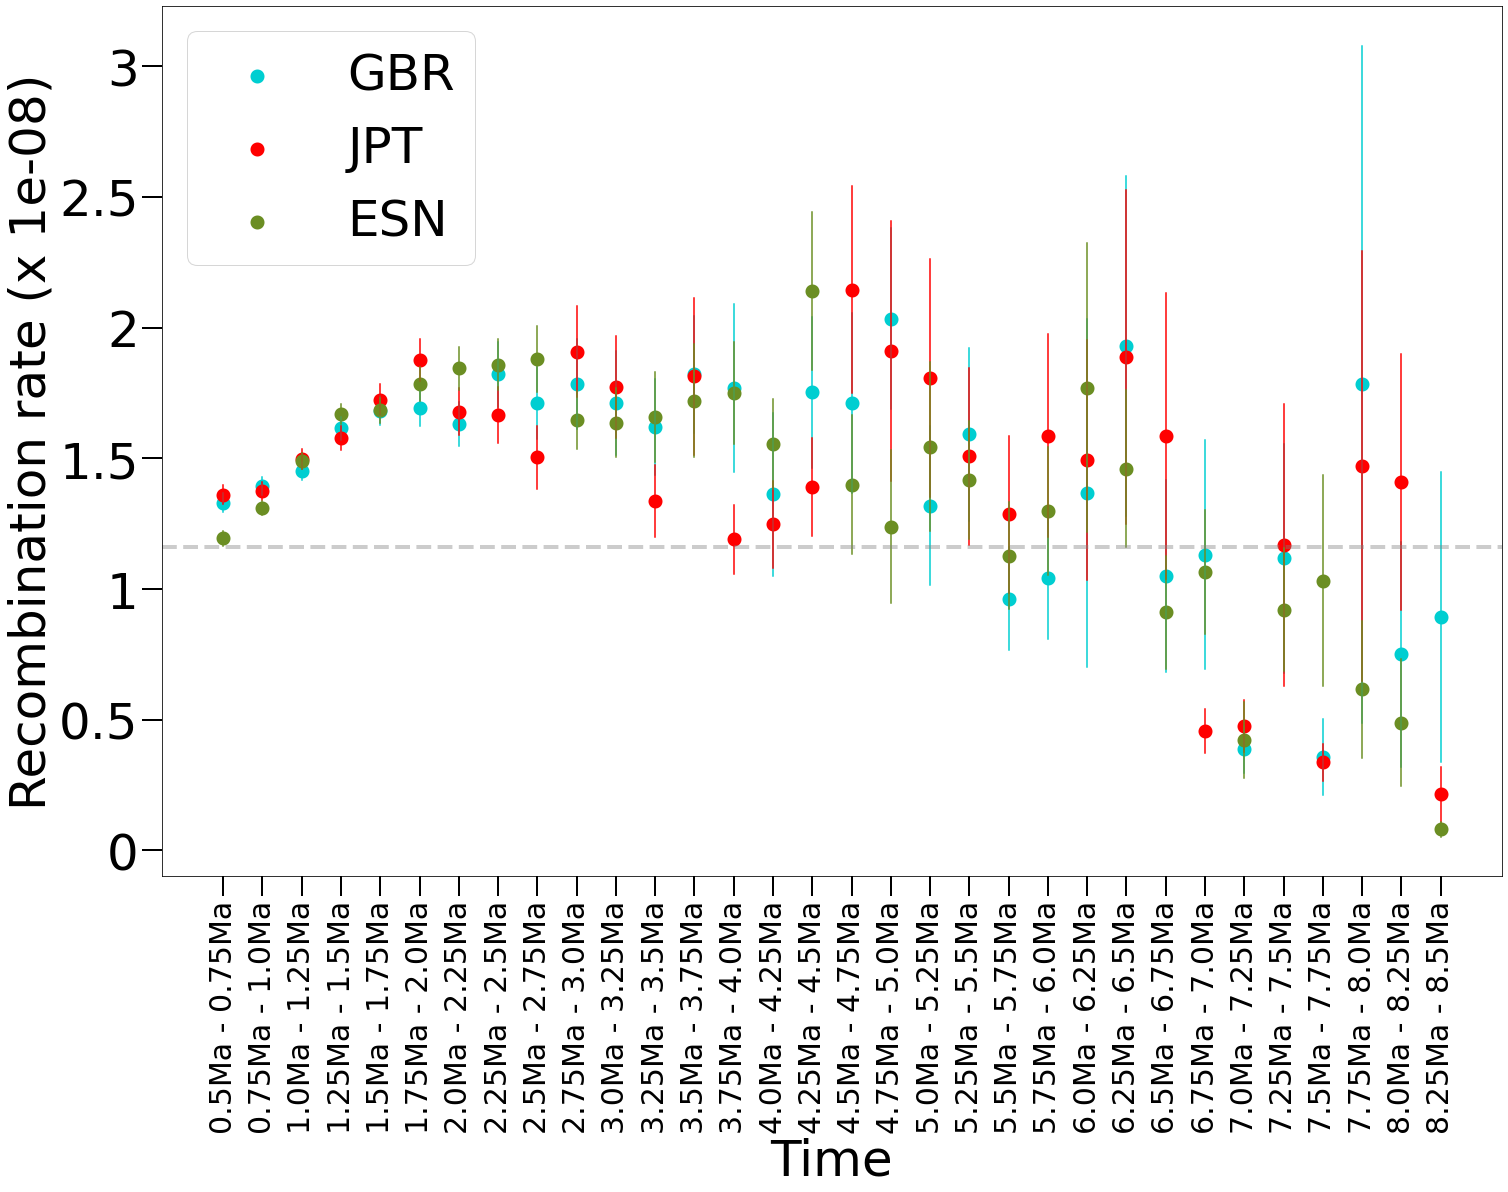

In [100]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    mean_r_rate = np.zeros(len(years_stratify)-1)
    standard_errors_r_rate = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<recombination_rate_map.right[-1]]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        r_rates_ = np.array([recombination_rate_map.get_rate(i) for i in tmrca_indices if mappabiltiy_seq[i]==1])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        zmean_r_rate = r_rates_.mean()
        zstderror = r_rates_.std()/np.sqrt(len(r_rates_))
        standard_errors_r_rate[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_r_rate[y] = zmean_r_rate
    plt.scatter(np.arange(0,len(mean_r_rate),1),mean_r_rate,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_r_rate),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(mean_r_rate),1)
    yz = mean_r_rate
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
#     plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(mean_r_rate):
        plt.plot((c,c),(mean_r_rate[c]-standard_errors_r_rate[c],mean_r_rate[c]+standard_errors_r_rate[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Recombination rate (x 1e-08)')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
# plt.ylim(0,)
plt.legend()    
plt.axhline(recombination_rate_map.mean_rate,linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plt.yticks([0,0.5e-8,1e-8,1.5e-8,2e-8,2.5e-8,3e-8],['0','0.5','1','1.5','2','2.5','3']);
plot_name = f"plot_correlation_recombmap_TMRCA"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plt.show()

zpopsam=GBR_HG00118
	=slope = -1.8881771608193754e-10
		Pearson correlation: -0.44746295786768603, p-value: 0.007967472749953458
		Spearman correlation: -0.3307868601986249, p-value: 0.056025108066352414
zpopsam=JPT_NA18939
	=slope = -1.8820930615326764e-10
		Pearson correlation: -0.40577422339398594, p-value: 0.017265776526848416
		Spearman correlation: -0.2935064935064935, p-value: 0.0920382379287034
zpopsam=ESN_HG03515
	=slope = -2.4286208329202047e-10
		Pearson correlation: -0.5022683777672625, p-value: 0.0024705363472050756
		Spearman correlation: -0.4756302521008403, p-value: 0.004469093782757615


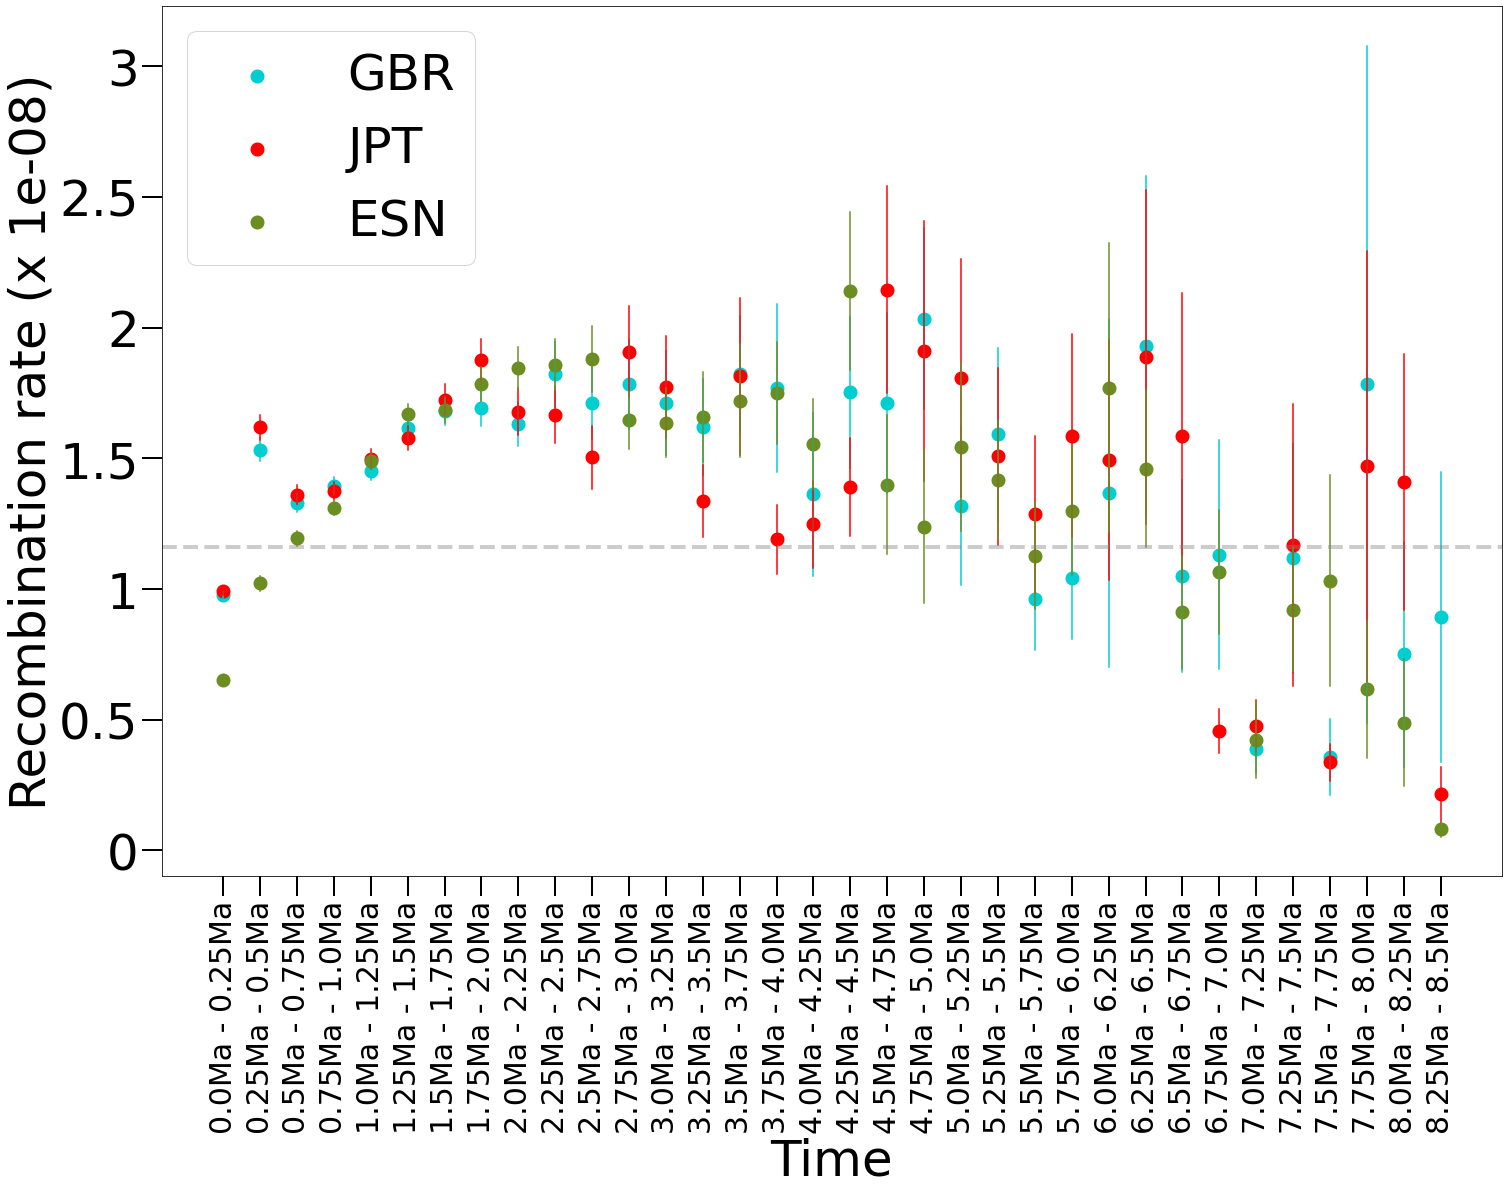

In [101]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(0,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    mean_r_rate = np.zeros(len(years_stratify)-1)
    standard_errors_r_rate = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<recombination_rate_map.right[-1]]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        r_rates_ = np.array([recombination_rate_map.get_rate(i) for i in tmrca_indices if mappabiltiy_seq[i]==1])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        zmean_r_rate = r_rates_.mean()
        zstderror = r_rates_.std()/np.sqrt(len(r_rates_))
        standard_errors_r_rate[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_r_rate[y] = zmean_r_rate
    plt.scatter(np.arange(0,len(mean_r_rate),1),mean_r_rate,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_r_rate),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(mean_r_rate),1)
    yz = mean_r_rate
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
#     plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(mean_r_rate):
        plt.plot((c,c),(mean_r_rate[c]-standard_errors_r_rate[c],mean_r_rate[c]+standard_errors_r_rate[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Recombination rate (x 1e-08)')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
# plt.ylim(0,)
plt.legend()    
plt.axhline(recombination_rate_map.mean_rate,linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plt.yticks([0,0.5e-8,1e-8,1.5e-8,2e-8,2.5e-8,3e-8],['0','0.5','1','1.5','2','2.5','3']);
plot_name = f"plot_correlation_recombmap_TMRCA"
plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plt.show()

zpopsam=GBR_HG00118
	=slope = -0.002255638651339942
		Pearson correlation: -0.05967858840260187, p-value: 0.8026429361665841
		Spearman correlation: 0.7368421052631579, p-value: 0.00021080775336363285
zpopsam=JPT_NA18939
	=slope = -0.0022556386380713817
		Pearson correlation: -0.059678588051015447, p-value: 0.8026429373073162
		Spearman correlation: 0.7052631578947368, p-value: 0.0005141445995748775
zpopsam=ESN_HG03515
	=slope = 5.953243565296121e-10
		Pearson correlation: 0.9462290337410052, p-value: 2.9339253959788925e-10
		Spearman correlation: 0.9654135338345864, p-value: 5.932418372864708e-12


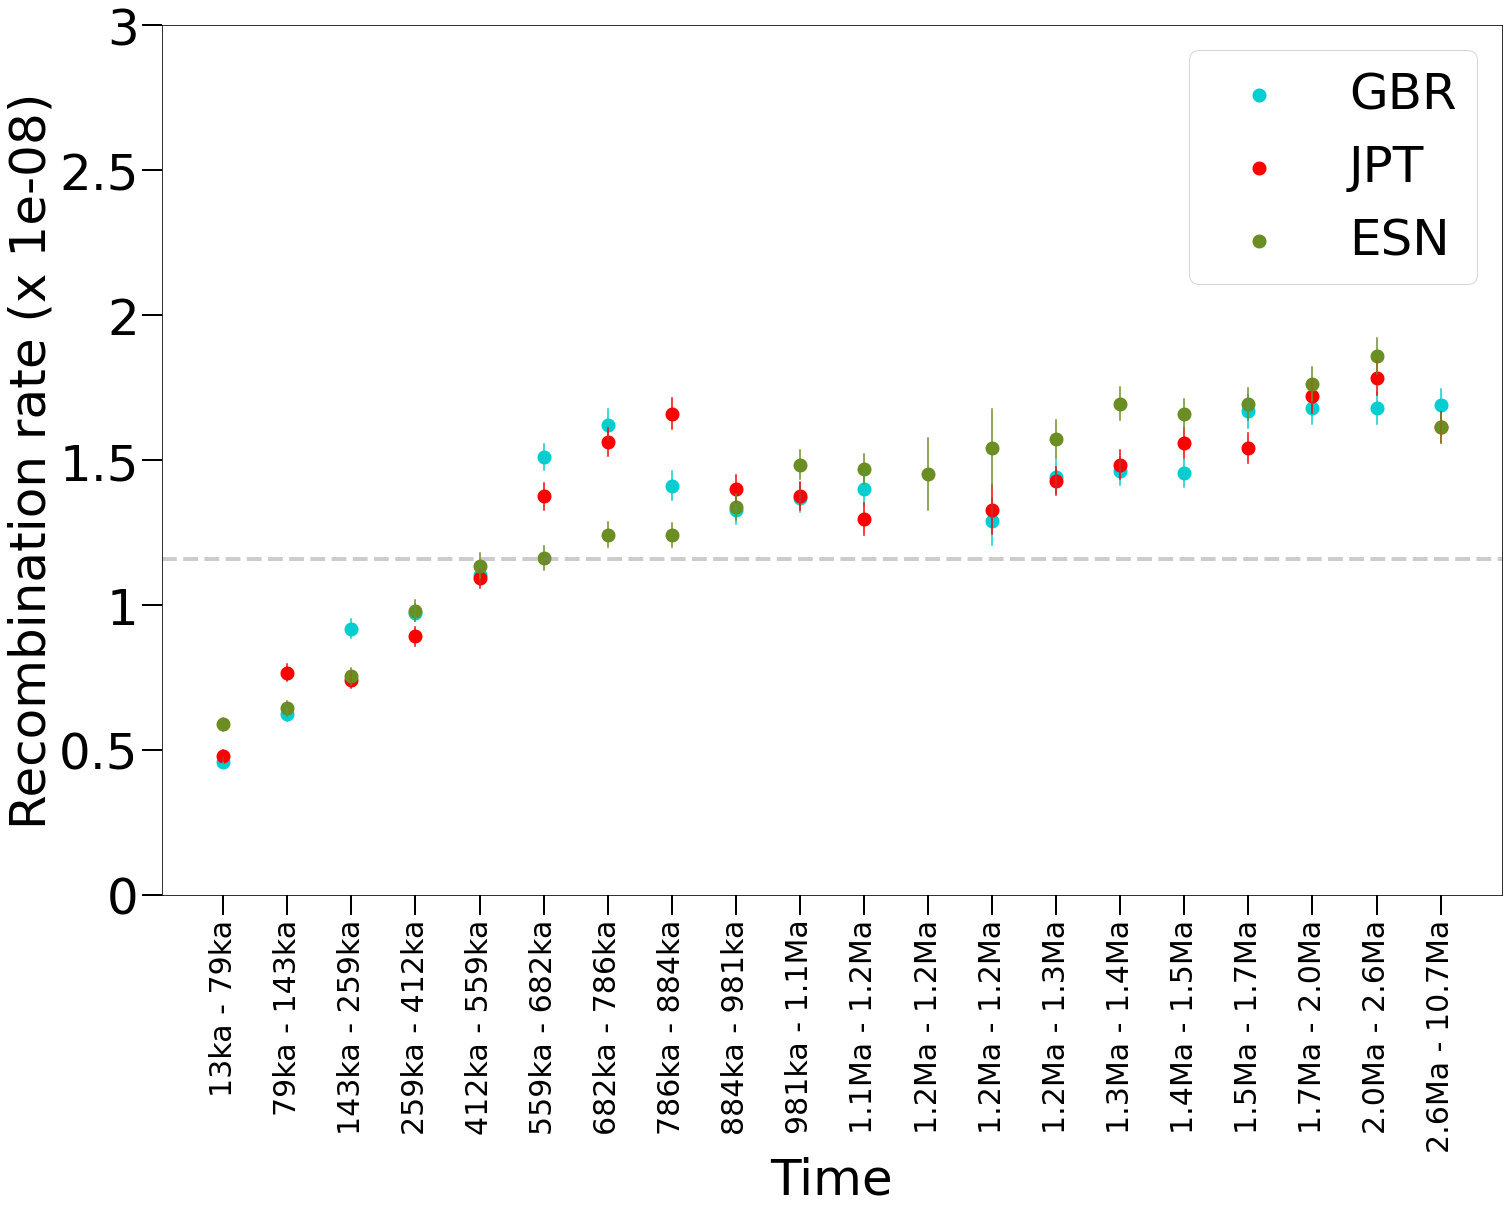

In [68]:
# stratify x-axis by amount of data

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    num_percentiles = 20
    years_stratify = np.array([np.percentile(posterior_mean_pops_chr1[zpopsam],int(i)) for i in np.arange(0,100+100//num_percentiles,100//num_percentiles)])
    mean_r_rate = np.zeros(len(years_stratify)-1)
    standard_errors_r_rate = np.zeros(len(years_stratify)-1)
    boundaries_xlabs = [f'{convert_years_to_sci_notation(years_stratify[i])} - {convert_years_to_sci_notation(years_stratify[i+1])}' for i in range(0,len(years_stratify)-1)]
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<recombination_rate_map.right[-1]]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        r_rates_ = np.array([recombination_rate_map.get_rate(i) for i in tmrca_indices if mappabiltiy_seq[i]==1 and np.isnan(recombination_rate_map.get_rate(i))==False])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        if len(r_rates_)==0:
            zmean_r_rate=-1
        else:
            zmean_r_rate = r_rates_.mean()
        zstderror = r_rates_.std()/np.sqrt(len(r_rates_))
        standard_errors_r_rate[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_r_rate[y] = zmean_r_rate
    plt.scatter(np.arange(0,len(mean_r_rate),1),mean_r_rate,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_r_rate),1),labels=boundaries_xlabs,rotation=90,fontsize=30)
    
    xz = np.arange(0,len(mean_r_rate),1)
    yz = mean_r_rate
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
#     plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(mean_r_rate):
        plt.plot((c,c),(mean_r_rate[c]-standard_errors_r_rate[c],mean_r_rate[c]+standard_errors_r_rate[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Recombination rate (x 1e-08)')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
plt.ylim(0,3e-08)
plt.legend()    
plt.axhline(recombination_rate_map.mean_rate,linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plt.yticks([0,0.5e-8,1e-8,1.5e-8,2e-8,2.5e-8,3e-8],['0','0.5','1','1.5','2','2.5','3']);
# plot_name = f"plot_correlation_recombmap_TMRCA"
# plt.savefig(f'{path_prefix_figures}/{plot_name}_{path_suffix}',bbox_inches='tight')  
plt.show()

zpopsam=GBR_HG00118
	=slope = 2328.971485766619
		Pearson correlation: 0.4412067032863265, p-value: 0.051493396086516034
		Spearman correlation: 0.7218045112781954, p-value: 0.0003270659389347304
zpopsam=JPT_NA18939
	=slope = 1646.7212208305457
		Pearson correlation: 0.31209822985490876, p-value: 0.18036710443580267
		Spearman correlation: 0.5428571428571428, p-value: 0.01338720542801516
zpopsam=ESN_HG03515
	=slope = 1725.5406625114776
		Pearson correlation: 0.7794271901092786, p-value: 5.103370664322382e-05
		Spearman correlation: 0.8210526315789473, p-value: 9.148582181124773e-06


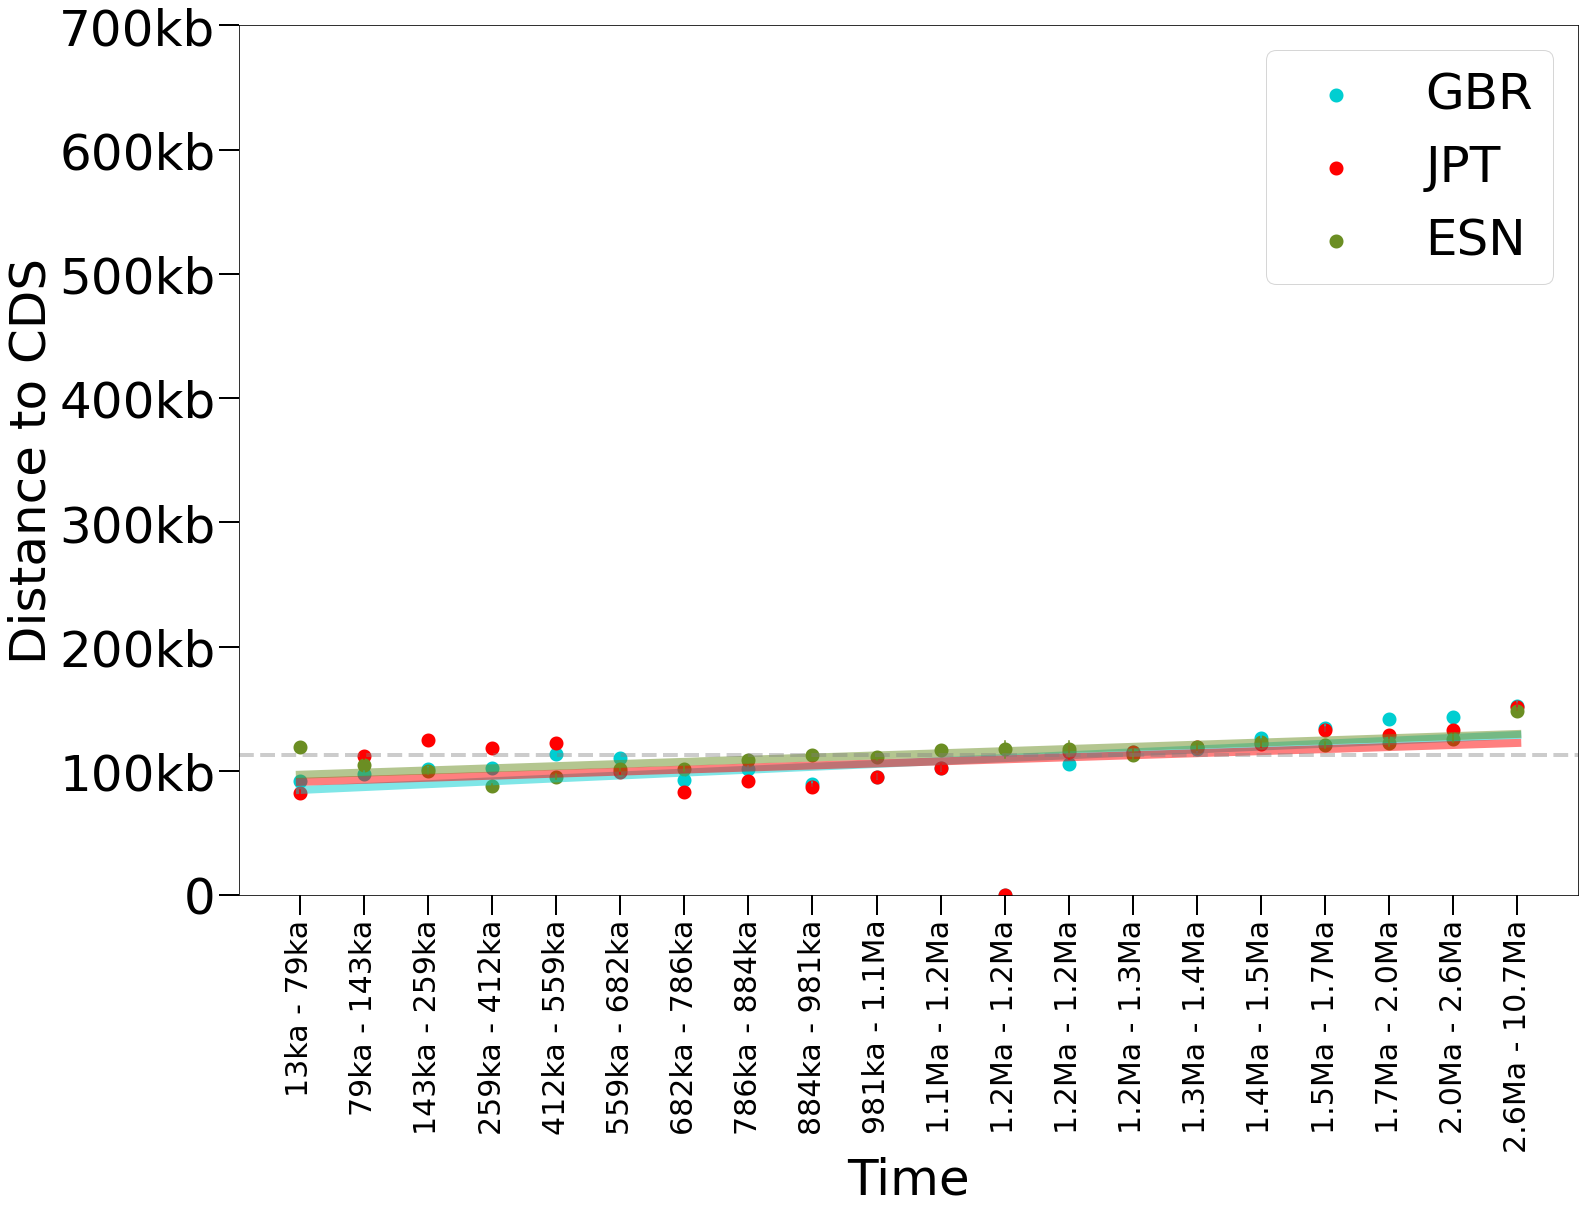

In [83]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    num_percentiles = 20
    years_stratify = np.array([np.percentile(posterior_mean_pops_chr1[zpopsam],int(i)) for i in np.arange(0,100+100//num_percentiles,100//num_percentiles)])
    boundaries_xlabs = [f'{convert_years_to_sci_notation(years_stratify[i])} - {convert_years_to_sci_notation(years_stratify[i+1])}' for i in range(0,len(years_stratify)-1)]

    mean_disttoCDS = np.zeros(len(years_stratify)-1)
    standard_errors_disttoCDS = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<len(distance_to_CDS)]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        zdistance_to_CDS = np.array([distance_to_CDS[i] for i in tmrca_indices if mappabiltiy_seq[i]==1])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        if len(zdistance_to_CDS)==0:
            mean_distance_to_CDS = -100
        else:
            mean_distance_to_CDS = zdistance_to_CDS.mean()
        zstderror = zdistance_to_CDS.std()/np.sqrt(len(zdistance_to_CDS))
        standard_errors_disttoCDS[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_disttoCDS[y] = mean_distance_to_CDS
    plt.scatter(np.arange(0,len(mean_disttoCDS),1),mean_disttoCDS,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_disttoCDS),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(mean_disttoCDS),1)
    yz = mean_disttoCDS
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
    plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_disttoCDS):
        plt.plot((c,c),(mean_disttoCDS[c]-standard_errors_disttoCDS[c],mean_disttoCDS[c]+standard_errors_disttoCDS[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Distance to CDS')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
# plt.ylim(0,)
plt.ylim(0,700000)
plt.legend()    
plt.axhline(distance_to_CDS[zpass_mappability_indices].mean(),linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plt.yticks([0,100000,200000,300000,400000,500000,600000,700000],[0,'100kb','200kb','300kb','400kb','500kb','600kb','700kb']);

zpopsam=GBR_HG00118


/home/tc557/miniconda3/envs/snakemake_new/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tc557/miniconda3/envs/snakemake_new/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/tc557/miniconda3/envs/snakemake_new/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	=slope = 2328.971485766619
		Pearson correlation: 0.4412067032863265, p-value: 0.051493396086516034
		Spearman correlation: 0.7218045112781954, p-value: 0.0003270659389347304
zpopsam=JPT_NA18939
	=slope = 1646.7212208305457
		Pearson correlation: 0.31209822985490876, p-value: 0.18036710443580267
		Spearman correlation: 0.5428571428571428, p-value: 0.01338720542801516
zpopsam=ESN_HG03515
	=slope = 1725.5406625114776
		Pearson correlation: 0.7794271901092786, p-value: 5.103370664322382e-05
		Spearman correlation: 0.8210526315789473, p-value: 9.148582181124773e-06


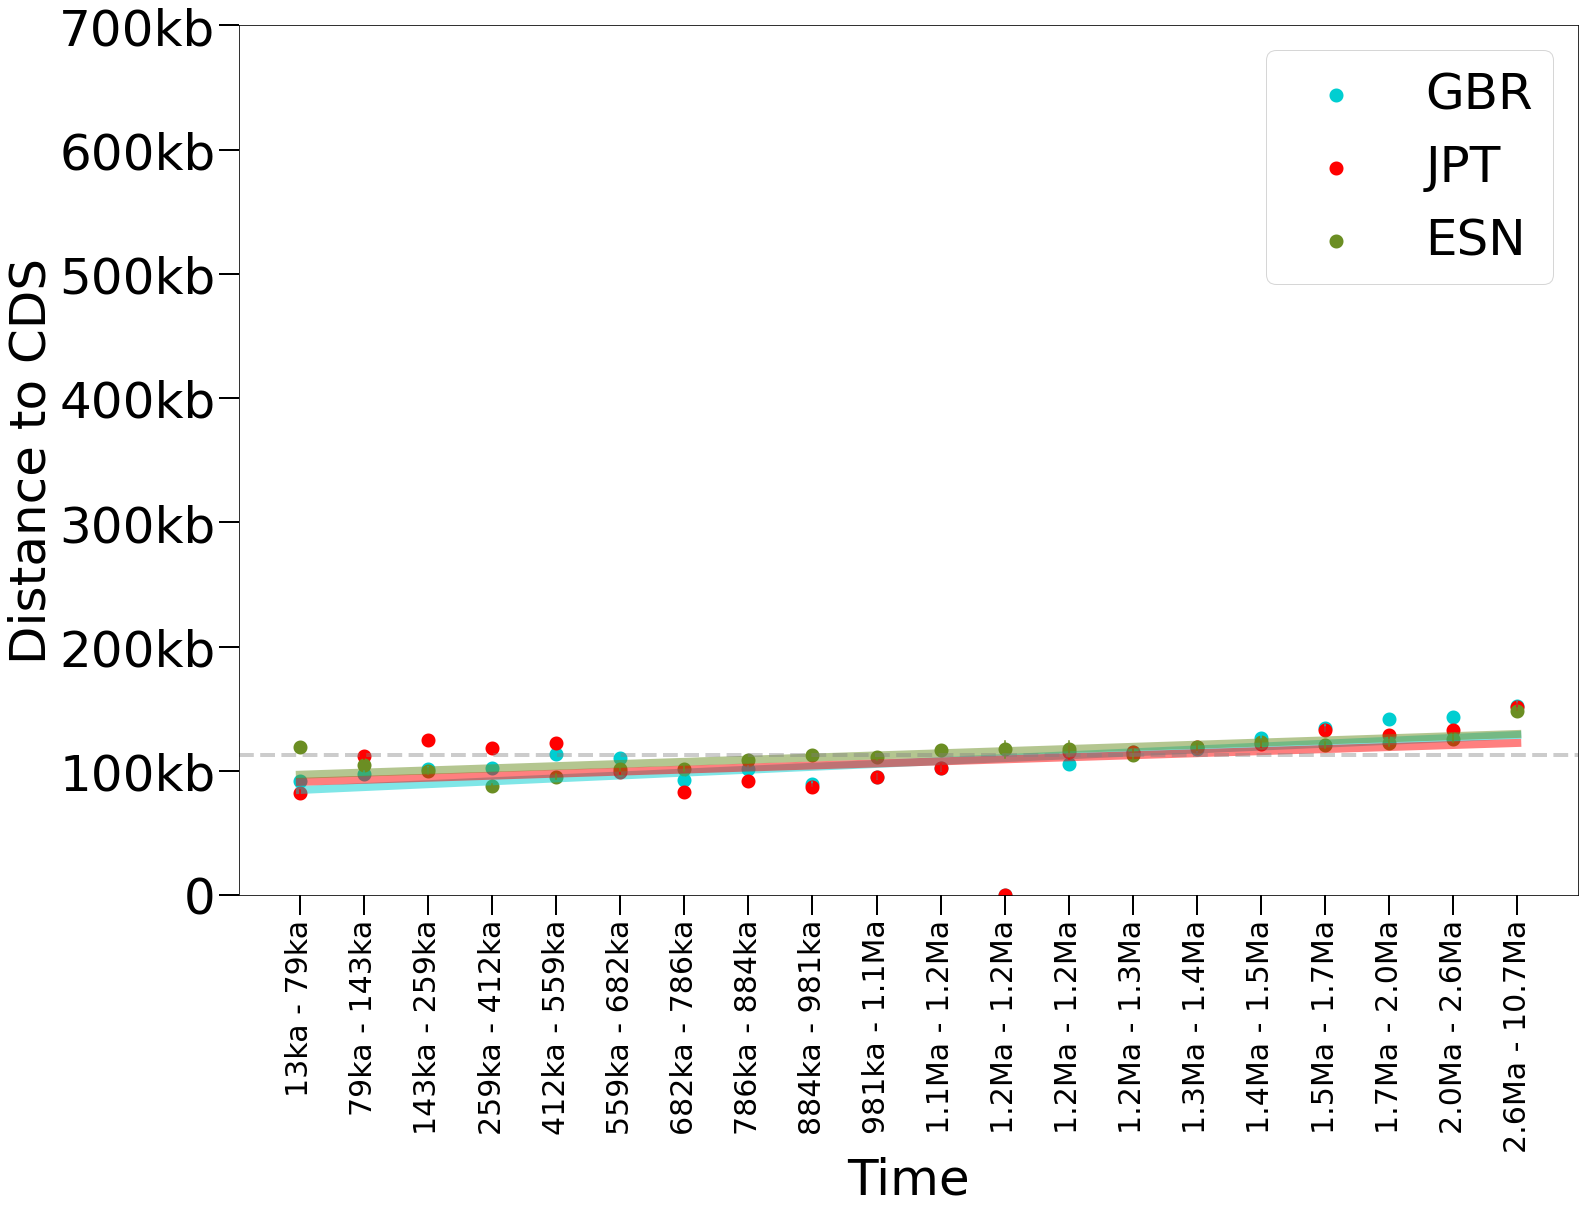

In [74]:

# years_stratify = np.arange(5e+05,1e+07,2.5e+05)
years_stratify = np.arange(5e+05,8.75e+06,2.5e+05)

boundaries_xlabs = [f'{years_stratify[i]/1000000}Ma - {years_stratify[i+1]/1000000}Ma' for i in range(0,len(years_stratify)-1)]

pop_and_sample_ofinterest = ['GBR_HG00118','JPT_NA18939','ESN_HG03515']

for zpopsam in pop_and_sample_ofinterest:
    print(f'zpopsam={zpopsam}')
    num_percentiles = 20
    years_stratify = np.array([np.percentile(posterior_mean_pops_chr1[zpopsam],int(i)) for i in np.arange(0,100+100//num_percentiles,100//num_percentiles)])
    boundaries_xlabs = [f'{convert_years_to_sci_notation(years_stratify[i])} - {convert_years_to_sci_notation(years_stratify[i+1])}' for i in range(0,len(years_stratify)-1)]

    mean_disttoCDS = np.zeros(len(years_stratify)-1)
    standard_errors_disttoCDS = np.zeros(len(years_stratify)-1)
#     zpopsam = 'YRI_NA18488'
    zpop = zpopsam.split('_')[0]
    step_size = 1000
    tmrcas_seq = tmrcas_to_seq(posterior_mean_pops_chr1[zpopsam],posterior_mean_pops_chr1[f'{zpopsam}_position'])
    zlength = len(tmrcas_seq)
    zpositions = np.arange(0,zlength,step_size) 
    for y,years_boundaries in enumerate(years_stratify[0:-1]):
        y_lower = years_stratify[y]
        y_upper = years_stratify[y+1]
        tmrca_indices = np.array([i for i in zpositions if tmrcas_seq[i]>=y_lower and tmrcas_seq[i]<y_upper])
        tmrca_indices = tmrca_indices[tmrca_indices<len(distance_to_CDS)]
        if len(tmrca_indices)==0:
            print(f'skipping y={y}; zpop={zpop}')
            continue
        zdistance_to_CDS = np.array([distance_to_CDS[i] for i in tmrca_indices if mappabiltiy_seq[i]==1])
        
    #     ztmrcas = tmrcas_seq[CpGIslands_indices]
        if len(zdistance_to_CDS)==0:
            mean_distance_to_CDS = -100
        else:
            mean_distance_to_CDS = zdistance_to_CDS.mean()
        zstderror = zdistance_to_CDS.std()/np.sqrt(len(zdistance_to_CDS))
        standard_errors_disttoCDS[y] = zstderror
    #     print(f'\ty_lower={y_lower}; y_upperr={y_upper};\n\t\tpercentage in repeat = {int(100*fraction_in_repeat)}')
    #     print(f'\t\tnumber data points = {len(tmrca_indices)}')
    #     print(f'\t\tnumber repeats = {len(repeat_mappability_indices)}')
        mean_disttoCDS[y] = mean_distance_to_CDS
    plt.scatter(np.arange(0,len(mean_disttoCDS),1),mean_disttoCDS,linewidth=8,color=pop_colors[zpop],label=zpop)
    plt.xticks(ticks=np.arange(0,len(mean_disttoCDS),1),labels=boundaries_xlabs,rotation=90,fontsize=30)

    
    xz = np.arange(0,len(mean_disttoCDS),1)
    yz = mean_disttoCDS
    a, b = np.polyfit(xz, yz, 1)
    print(f'\t=slope = {a}')
    plt.plot(xz, a*xz+b,alpha=0.5,linewidth=8,color=pop_colors[zpop])
    pearson_corr, pearson_pvalue = stats.pearsonr(xz, yz)
    # Spearman correlation
    spearman_corr, spearman_pvalue = stats.spearmanr(xz, yz)
    # Output results
    print(f"\t\tPearson correlation: {pearson_corr}, p-value: {pearson_pvalue}")
    print(f"\t\tSpearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

    for c,i in enumerate(standard_errors_disttoCDS):
        plt.plot((c,c),(mean_disttoCDS[c]-standard_errors_disttoCDS[c],mean_disttoCDS[c]+standard_errors_disttoCDS[c]),color=pop_colors[zpop])
plt.xlabel('Time')
plt.ylabel('Distance to CDS')
plt.tick_params('both', length=20, width=2, which='major')
plt.tick_params('both', length=15, width=2, which='minor')
# plt.ylim(0,)
plt.ylim(0,700000)
plt.legend()    
plt.axhline(distance_to_CDS[zpass_mappability_indices].mean(),linewidth=4,alpha=0.4,linestyle="dashed",color="grey")
plt.yticks([0,100000,200000,300000,400000,500000,600000,700000],[0,'100kb','200kb','300kb','400kb','500kb','600kb','700kb']);

## How many ancient segments?

In [26]:
def remove_contiguous_segments(old_positions,step_size=1000):
    old_non_contiguous_positions = [old_positions[0]]
    for i in range(1,len(old_positions)):
        if old_positions[i]!=old_positions[i-1]+step_size:
#             if i==3:
#                 pdb.set_trace()
            old_non_contiguous_positions.append(old_positions[i])
    return np.array(old_non_contiguous_positions)

        
def remove_contiguous_segments_new(old_positions,step_size=1000):
    zindices = np.where(old_positions[:-1]-old_positions[1:]+step_size!=0)[0]
    return old_positions[zindices]

In [20]:
D = 64
b = 100
spread1 = 0.075
spread2 = 50
iterations = 30
thresh = 1
muoverr = 1.5 # starting mu over r ratio
fixedtheta = 0.0008
chroms = range(1,23)
T = time_intervals(D,spread1,spread2)
gen = 29
mu=1.25e-08
thetafixed=0.0008
N = thetafixed/(4*mu)
T_gens = T*2*N
T_years = T_gens*29
step_size=1000


In [ ]:

posteriors_pops_chroms = {}
for popsam in pop_and_sample_africans:
    posteriors_pops_chroms[popsam] = {}
    print(f'popsam={popsam}')
    for chrom in range(1,23):
        print(f'\tchrom={chrom}')
        posteriors_pops_chroms[popsam][chrom] = {}
        filename = f'/home/tc557/rds/hpc-work/PSMCplus_analysis_240813/240813/D_{D}/b_{b}/spread1_{spread1}/spread2_{spread2}/muoverr_{muoverr}/iterations{iterations}/thresh_{thresh}/thetafixed_{thetafixed}/popsample_{popsam}/chr{chrom}_decode.txt.gz'
        position_decoding = np.loadtxt(filename)
        position = position_decoding[0,:]
        posteriors_pops_chroms[popsam][chrom]['position'] = position
        posterior = position_decoding[1:,:]
        posteriors_pops_chroms[popsam][chrom]['posterior'] = posterior
        
        

    #     print(f'zpdf.sum() = {zpdf.sum()}')

In [49]:
pop_age_minprob_numpositions = {}
for popsam in pop_and_sample_africans:
    pop_age_minprob_numpositions[popsam] = {}
    for desired_age in [1e+06,2e+06,3e+06,4e+06,5e+06,6e+06]:
        pop_age_minprob_numpositions[popsam][desired_age] = {}
        desired_age_index = np.where(T_years>desired_age)[0][0]
        for min_probability in [0.7,0.8,0.9,0.95]:
            print(f'min_probability={min_probability}')
            print(f'\tdesired_age={desired_age}')
            for popsam in [popsam]:
                print(f'\t\ton popsam={popsam}')
                positions_counts = 0
                positions_counts_prev = 0
                
                for chrom in range(1,23):
            #         print(f'\ton chrom={chrom}')
                    zlength = posteriors_pops_chroms[popsam][chrom]['posterior'].shape[1]
                    old_positions = []
                    for i in range(0,zlength):
                        if posteriors_pops_chroms[popsam][chrom]['posterior'][desired_age_index:,i].sum()>min_probability:
                            old_positions.append(i)
                    old_positions=np.array(old_positions)*step_size
                    if len(old_positions)==0:
                        print(f'No segments!!! Skipping.')
                        continue
                    old_non_contiguous_positions_prev = remove_contiguous_segments(old_positions,step_size=1000)
                    positions_counts_chrom_prev=len(old_non_contiguous_positions_prev)
                    old_non_contiguous_positions = remove_contiguous_segments_new(old_positions,step_size=1000)
                    positions_counts_prev+=positions_counts_chrom_prev
                    positions_counts_chrom=len(old_non_contiguous_positions)
            #         print(f'\t\tnum_positions={positions_counts_chrom}')
                    positions_counts+=positions_counts_chrom
                print(f'\t\t\tTotal number of positions = {positions_counts}')
                print(f'\t\t\tTotal number of positions_prev = {positions_counts_prev}')
                pop_age_minprob_numpositions[popsam][desired_age][min_probability] = positions_counts
            

min_probability=0.7
	desired_age=1000000.0
		on popsam=ESN_HG03515
			Total number of positions = 62461
			Total number of positions_prev = 62483
min_probability=0.8
	desired_age=1000000.0
		on popsam=ESN_HG03515
			Total number of positions = 60159
			Total number of positions_prev = 60181
min_probability=0.9
	desired_age=1000000.0
		on popsam=ESN_HG03515
			Total number of positions = 54169
			Total number of positions_prev = 54191
min_probability=0.95
	desired_age=1000000.0
		on popsam=ESN_HG03515
			Total number of positions = 46579
			Total number of positions_prev = 46601
min_probability=0.7
	desired_age=2000000.0
		on popsam=ESN_HG03515
			Total number of positions = 29390
			Total number of positions_prev = 29412
min_probability=0.8
	desired_age=2000000.0
		on popsam=ESN_HG03515
			Total number of positions = 23391
			Total number of positions_prev = 23413
min_probability=0.9
	desired_age=2000000.0
		on popsam=ESN_HG03515
			Total number of positions = 17213
			Total number of 

In [33]:
filename = '/home/tc557/cobraa_plots/number_of_ancient_segments_from_posterior_241017.pickle'
with open(filename,'wb') as f:
    pickle.dump(pop_age_minprob_numpositions,f)

In [134]:
filename = '/home/tc557/cobraa_plots/number_of_ancient_segments_from_posterior_241005.pickle'
with open(filename,'wb') as f:
    pickle.dump(pop_age_minprob_numpositions,f)

In [52]:
def column_in_number(number):
    num_string = str(number)
    if len(num_string)==5:
        new_num_string = num_string[0:2] + ',' + num_string[2:]
    elif len(num_string)==4:
        new_num_string = num_string[0] + ',' + num_string[1:]
        
    return new_num_string

def column_in_number_new(number):
    num_string = str(number)
    new_num_string = num_string
    if len(num_string)==5:
        new_num_string = num_string[0:2] + ',' + num_string[2:]
    elif len(num_string)==4:
        new_num_string = num_string[0] + ',' + num_string[1:]
        
    return new_num_string

In [53]:
min_probability=0.9
print('Population & Sample  & 1Mya & 2Mya & 3Mya & 4Mya & 5Mya & 6Mya \\\\ \\hline')
for popsam in pop_and_sample_africans:
    print(f'{popsam.split("_")[0]} & {popsam.split("_")[1]} & ',end='')
    for desired_age in [1e+06,2e+06,3e+06,4e+06,5e+06,6e+06]:
        if desired_age==6e+06:
            zend=' \\\\'
        else:
            zend=' & '
        print(f'{column_in_number_new(pop_age_minprob_numpositions[popsam][desired_age][min_probability])} ',end=zend)
    print('\n',end='')

Population & Sample  & 1Mya & 2Mya & 3Mya & 4Mya & 5Mya & 6Mya \\ \hline
ESN & HG03515 & 54,169  & 17,213  & 7,811  & 3,952  & 1,841  & 472  \\
YRI & NA18488 & 54,486  & 17,229  & 7,668  & 3,841  & 1,752  & 426  \\
MSL & HG03212 & 53,817  & 17,243  & 7,661  & 3,910  & 1,947  & 494  \\
GWD & HG02568 & 54,493  & 16,893  & 7,358  & 3,667  & 1,721  & 397  \\
ACB & HG01882 & 55,368  & 17,590  & 7,883  & 4,129  & 1,909  & 457  \\
ASW & NA19625 & 54,974  & 17,395  & 7,798  & 3,984  & 1,852  & 439  \\
LWK & NA19017 & 54,644  & 17,709  & 8,105  & 4,050  & 1,874  & 496  \\
